# Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
**Concepts Tools and Techniques to Build Intelligent Systems**  
  
My notes along the way.  
Bonnie Cooper

<br>

## Chapter 1: The Machine Learning Landscape

**Machine Learning is**....  

* the science/art of programming computers so that they can learn from data
* the field of study that gives computers the ability to learn without being explicitly programmed
* A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T as measured by P inproves with experience E.

**Human Supervision**  

* Supervised - the training set that is fed to the algorithm contains the solution (labels). For example, classification, linear regression, kNN, logistic regression, SVM, Decision Trees and Random Forests, Neural Networks
* Unsupervised - the training data is unlabelled. For example: clustering, anomoly/novelty detection, dimentionality reduction (e.g. PCA), Association rule learning
* Semisupervised - partially labelled data and are generally combinations of supervised and unsupervised algotithms. For example, deep belief networks
* Reinforcement Learning - the learining system can observe the environment, select actions to perform. It then can get rewards for good outcomes, penalties for bad outcomes or both. From these new outcomes, the system updates it's strategy/policy accordingly.

**Batch (offline) Learning** - the system is incapable of learning incrementally: it must be trained using all the available data typically offline. The system is trained, and then it is launched intp production and runs without learning anymore.  
**Online Learning** - the system is trained incrementally by feeding it data instances squentially, either individual instances or small groups called *mini-batches*. Each learning step is fast and cheap, so the system can learn about new data on the fly.  

**Generalize** - how does the model/system perform with new data?  
**Instance-based Learning** - the system learns the examples by heart, then generalizes to new cases by using a similarity measure to compare them to the learned examples.  
**Model-based Learning** - build a model of the examples and use the model to make predictions on new data. Steps include: model selection, using a performance measure to evaluate model performance (utility or cost function), train the model, then run on unseen data.  

<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

In [3]:
# load the data
url_oecd = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/lifesat/oecd_bli_2015.csv'
url_gdp = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/lifesat/gdp_per_capita.csv'

oecd_bli = pd.read_csv( url_oecd, thousands=',' )
gdp_per_capita = pd.read_csv( url_gdp, thousands=',', delimiter='\t', encoding='latin1', na_values='n/a' )

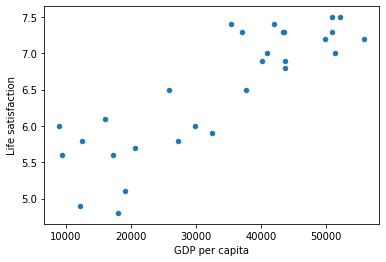

In [4]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

# prepare the data
country_stats = prepare_country_stats( oecd_bli, gdp_per_capita )
X = np.c_[ country_stats[ "GDP per capita" ] ]
y = np.c_[ country_stats[ "Life satisfaction" ] ]

# visualize the data
country_stats.plot( kind = 'scatter', x = 'GDP per capita', y = 'Life satisfaction' )
plt.show()

In [5]:
# linear regression prediction
model = sklearn.linear_model.LinearRegression()
model.fit( X,y )

# make a prediction for Cyprus (gdp = 22587)
X_new = [[22587]]
print( model.predict( X_new ) )

[[5.96242338]]


In [6]:
# kNN prediction
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor( n_neighbors=3 )
model.fit( X,y )

# make a prediction for Cyprus (gdp = 22587)
X_new = [[22587]]
print( model.predict( X_new ) )

[[5.76666667]]


<br>

Typical ML Workflow:  

* Study the Data
* Select the Model(s)
* Train the Model
* Make Predictions on New Cases

Things that can go wrong:  

* bad algorithm
    - **overfitting** - the model performs very well on training data, but fails to generalize to new instances. solution: **regularization** - make the model simpler to reduce the risk of overfitting
    - **underfitting** - occurs when the model is too simple to learn the underlying structure of the data.
* bad data
    - insufficient quantity of training data
    - nonrepresentative training data
    - poor quality (noisy/incomplete) data
    - irrelevant features

Testing and Validating:  

1. split the data in two sets: train & test
2. train your model on a training set and then test it on the test set
    - **hyperparameter tuning** - might need to sample multiple values for model parameter(s). it is best practice to hold out a portion of the training data as a validation set to evaluate model parameter performance
3. evaluate model performance with the test set: generalization error  

if the training error is low but the test error is high, this indicates the model is overfit to the training set.
<br>

<br>

## Chapter 2: End-to-End Machine Learning Project

<br>

Use California Census data to build a model of housing prices in the state.  

Follow the Machine Learning Project Checklist:  

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to Machine Learning Algorithms
5. Explore many different models and shortlist the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your solution

<br>

**Framing the Problem**: 
    
* exactly what is the business objective?
    - ex: the model should predict the district's median housing price and the projections will be fed to another machine learning system along with many other signals 
* what does the current solution look like? 
    - a reference for baseline performance
* select a performance metric
    - ex: RMSE for regression, or the cost function measured on the set of examples using your hypothesis *h*    $$\mbox{RMSE}(\mathbf{X},h)=\sqrt{\frac{1}{m}\sum^m_{i=1}(h(x^{(i)})-y^{(i)})^2}$$
    - ex: MAE for regression with outliers   $$\mbox{MAE}(\mathbf{X},h)=\frac{1}{m}\sum^m_{i=1}|h(x^{(i)})-y^{(i)}|$$
* check the assumptions
    
**pipeline** a sequence of data components  


In [7]:
#setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [8]:
#data
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
#an overview of the dataframe
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
#look at the categorical feature `ocean_proximity`
housing[ 'ocean_proximity' ].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
#look at the numeric attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


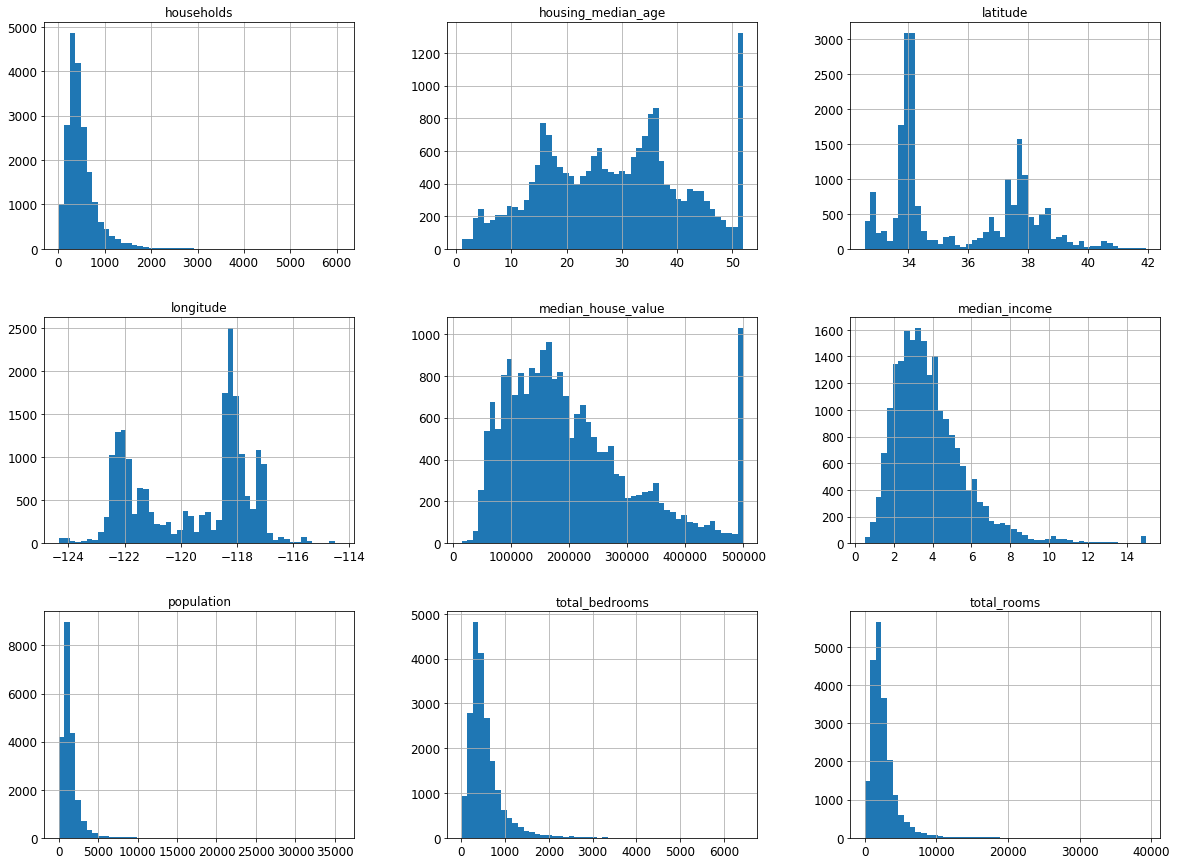

In [13]:
#visualize numeric attributes with histogrmas
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist( bins=50, figsize=(20,15 ) )
plt.show()

<br>

<font color=red>Wait! Before you look at the data any further, you need to create a text set, put it aside, and never look at it.</font>  

Pick some instances of the data at random, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

<br>

In [14]:
def split_train_test( data, test_ratio ):
    shuffled_indices = np.random.permutation( len( data ) )
    test_set_size = int( len( data ) * test_ratio )
    test_indices = shuffled_indices[ :test_set_size ]
    train_indices = shuffled_indices[ test_set_size: ]
    return data.iloc[ train_indices ], data.iloc[ test_indices ]

In [15]:
train_set, test_set = split_train_test( housing, 0.2 )
print( len( train_set ) )
print( len( test_set ) )

16512
4128


In [16]:
# a stable train/test split
from zlib import crc32

def test_set_check( identifier, test_ratio ):
    return crc32( np.int64( identifier ) ) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id( data, test_ratio, id_column ):
    ids = data[ id_column ]
    in_test_set = ids.apply( lambda id_: test_set_check( id_, test_ratio ) )
    return data.loc[ ~in_test_set ], data.loc[ in_test_set ]

In [17]:
housing_with_id = housing.copy()
housing_with_id[ 'id' ] = housing[ "longitude" ]*1000 + housing[ "longitude" ]
train_set, test_set = split_train_test_by_id( housing_with_id, 0.2, "id" )
print( len( train_set ) )
print( len( test_set ) )

16172
4468


In [18]:
#alternatively, can use sklearns method:
from sklearn.model_selection import train_test_split
tarin_set, test_set = train_test_split( housing, test_size = 0.2, random_state = 42 )

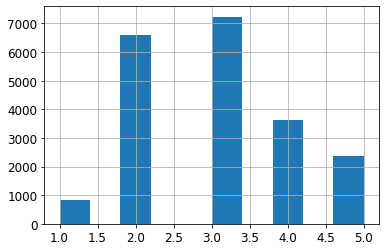

In [19]:
housing[ "income_cat" ] = pd.cut( housing[ "median_income" ],
                                bins = [ 0., 1.5, 3.0, 4.5, 6., np.inf ],
                                labels = [ 1,2,3,4,5 ] )
housing[ "income_cat" ].hist()
plt.show()

<br>

we observe that the instances do not have equal likelihood across the median income categories.  
to avoid **sampleing bias** we will use a stratefied sampling method

<br>

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit( n_splits = 1, test_size = 0.2, random_state = 42 )
for train_index, test_index in split.split( housing, housing[ "income_cat" ] ):
    strat_train_set = housing.loc[ train_index ]
    strat_test_set = housing.loc[ test_index ]

print( "stratefied" )    
print( strat_test_set[ "income_cat" ].value_counts() / len( strat_test_set ) )
print( 'native' )
print( housing[ "income_cat" ].value_counts() / len( housing ) )

stratefied
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64
native
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [21]:
#remove income_cat (redundant feature)
for set_ in ( strat_train_set, strat_test_set ):
    set_.drop( "income_cat", axis=1, inplace=True )

<br>

### Discover and Visualize the Data to Gain Insights

<br>

In [22]:
# work with the train set
housing = strat_train_set.copy()


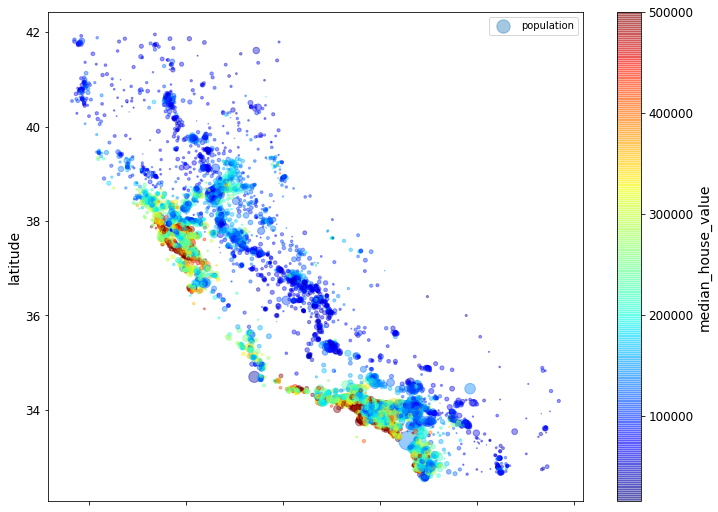

In [23]:
housing.plot( kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing[ "population"]/100, label = "population", figsize = (12,9),
            c = "median_house_value", cmap = plt.get_cmap( "jet" ), colorbar = True )
plt.show()

In [24]:
corr_matrix = housing.corr()
corr_matrix[ "median_house_value" ].sort_values( ascending = False )

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

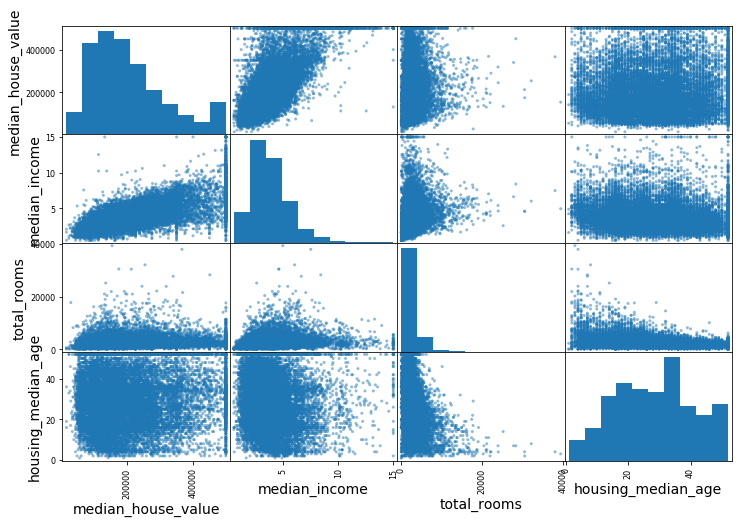

In [25]:
#visually inspect for correlations
from pandas.plotting import scatter_matrix
attributes = [ "median_house_value", "median_income", "total_rooms", "housing_median_age" ]
scatter_matrix( housing[ attributes ], figsize = ( 12,8 ) )
plt.show()

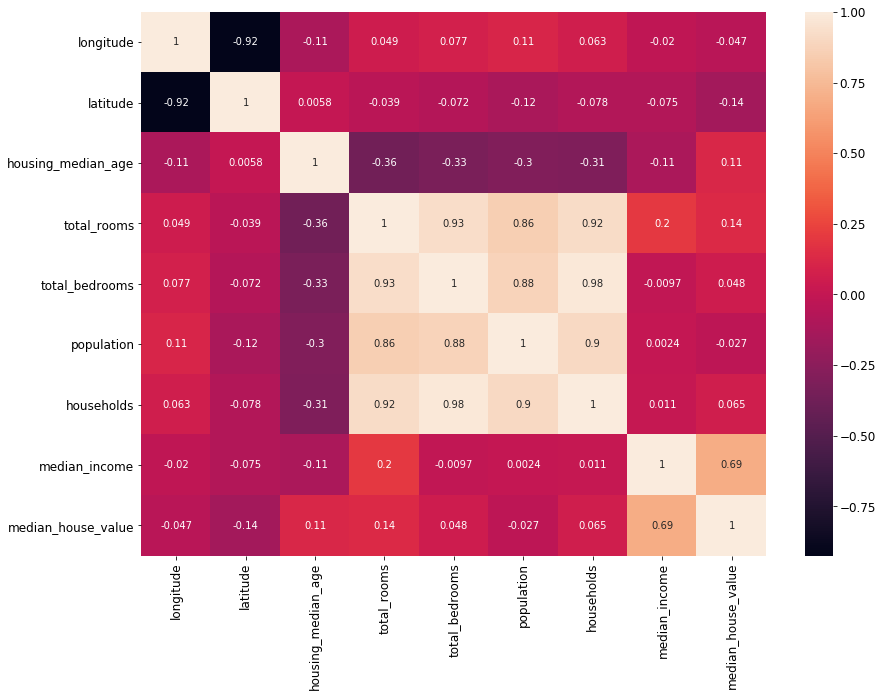

In [26]:
import seaborn as sns

Var_Corr = housing.corr()
# plot the heatmap and annotation on it
plt.figure(figsize=(14, 10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, 
            yticklabels=Var_Corr.columns, annot=True)
plt.show()

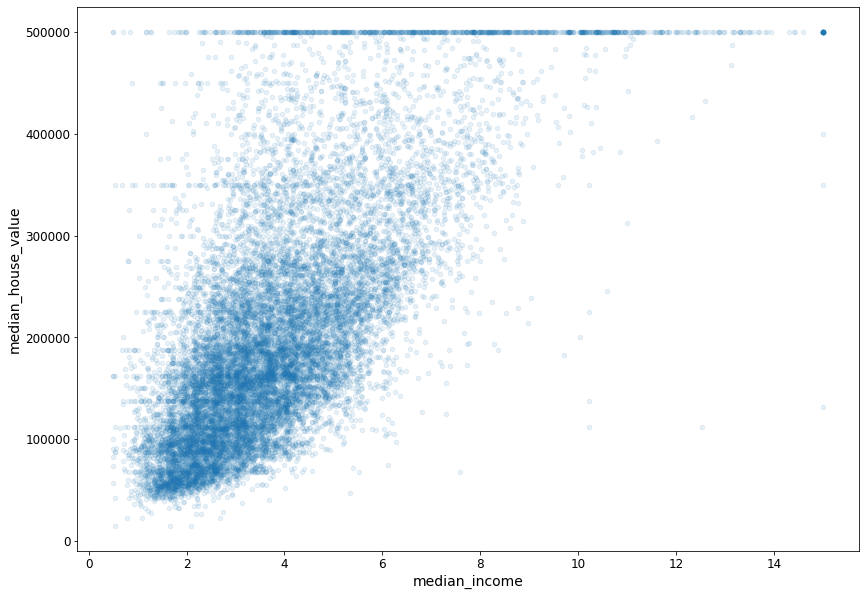

In [27]:
housing.plot( kind = "scatter", x = "median_income", y = "median_house_value", 
             alpha = 0.1, figsize=(14, 10) )
plt.show()

In [28]:
# experimenting with attribute combinations
housing[ "rooms_per_household" ] = housing[ "total_rooms" ]/housing[ "households" ]
housing[ "bedrooms_per_room" ] = housing[ "total_bedrooms" ]/housing[ "total_rooms" ]
housing[ "population_per_household" ] = housing[ "population" ]/housing[ "households" ]

In [31]:
corr_matrix = housing.corr()
corr_matrix[ "median_house_value" ].sort_values( ascending = False )

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<br>

### Preparing the Data for ML Algorithms

<br>

In [33]:
#make a fresh copy of feature variables and taget
housing = strat_train_set.drop( "median_house_value", axis=1 )
housing_labels = strat_train_set[ "median_house_value"].copy()

In [34]:
#Data cleaning
#missing values
housing.dropna( subset = [ "total_bedrooms" ] )
housing.drop( "total_bedrooms", axis = 1 )
median = housing[ "total_bedrooms" ].median()
housing[ "total_bedrooms" ].fillna( median, inplace = True )

In [35]:
#imputing values w/sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer( strategy = "median" )
housing_num = housing.drop( "ocean_proximity", axis = 1) #SimpleImputer needs just numeric features
imputer.fit( housing_num )

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
print( imputer.statistics_ )
print( housing_num.median() )

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64


In [38]:
#can use the trained imputer to transform other data (i.e. training set)
X = imputer.transform( housing_num )
house_tr = pd.DataFrame( X, columns = housing_num.columns,
                       index = housing_num.index )
house_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [39]:
#looking at the text attribute
housing_cat = housing[ "ocean_proximity" ]
housing_cat.head( 10 )

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
#convert from char to numeric representation
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform( housing_cat.values.reshape(-1,1) )
housing_cat_encoded[ :10 ]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [46]:
#show the corresponding category labels
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
#better for unordered categories
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform( housing_cat.values.reshape(-1,1) )
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [57]:
# a custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder( BaseEstimator, TransformerMixin ):
    def __init__( self, add_bedrooms_per_room = True ):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit( self, X, y=None ):
        return self
    def transform( self,X ):
        rooms_per_household = X[ :,rooms_ix ] / X[ :,households_ix ]
        population_per_household = X[ :,population_ix ] / X[ :,households_ix ]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[ :,bedrooms_ix ] / X[ :,rooms_ix ]
            return np.c_[ X, rooms_per_household, population_per_household,
                        bedrooms_per_room ]
        else:
            return np.c_[ X, rooms_per_household, population_per_household ]

In [59]:
attr_adder = CombinedAttributesAdder( add_bedrooms_per_room = False )
housing_extra_attribs = attr_adder.transform( housing.values )

<br>

**features scaling** ML algorithms don't perform well when the input numerical attributes have different scales  

* **min-max scaling** - `MinMaxScaler` - values are shifted and rescaled such that they end up ranging from 0 to 1. subtract the min value and divide by the max
* **standardization** - `StandardScaler` -stadardizes values to have a mean of 0. this is done by subtracting the mean values and dividing by the standard deviation.

<br>

In [60]:
# Transformatio Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline( [
    ( 'imputer', SimpleImputer( strategy = 'median' ) ),
    ( 'attribs_adder', CombinedAttributesAdder() ),
    ( 'std_scaler', StandardScaler() ),
] )

In [62]:
housing_num_tr = num_pipeline.fit_transform( housing_num )

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [63]:
# Transformation Pipeline that handles both num and cat simultaneously
from sklearn.compose import ColumnTransformer

num_attribs = list( housing_num )
cat_attribs = [ 'ocean_proximity' ]

full_pipeline = ColumnTransformer( [
    #( name, transformer, list(columns) )
    ( 'num', num_pipeline, num_attribs ),
    ( 'cat', OneHotEncoder(), cat_attribs ),
] )
#can use the remainder = 'passthrough' if there are columns that should remain untouched

In [66]:
housing_prepared = full_pipeline.fit_transform( housing )

<br>

### Select & Train a Model

<br>

In [68]:
# a simple linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit( housing_prepared, housing_labels )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
# fit the model to the data
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict( housing_prepared )
lin_mse = mean_squared_error( housing_labels, housing_predictions )
lin_rmse = np.sqrt( lin_mse )
lin_rmse

68628.19819848922

In [70]:
# a decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit( housing_prepared, housing_labels )

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [75]:
# cross-validation of the tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score( tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
tree_rmse_scores = np.sqrt( -scores )

In [76]:
# visualize the results
def display_scores( scores ):
    print( "Scores:", scores )
    print( "Mean:", scores.mean() )
    print( "Standard deviation", scores.std() )
    
display_scores( tree_rmse_scores )

Scores: [67955.52272124 66832.94214304 72035.74663073 69180.92884406
 70524.39035835 74926.08356551 70370.50216506 71957.00107648
 77180.779762   70577.94280585]
Mean: 71154.1840072325
Standard deviation 2934.448891655373


In [77]:
display_scores( tree_rmse_scores )

Scores: [67955.52272124 66832.94214304 72035.74663073 69180.92884406
 70524.39035835 74926.08356551 70370.50216506 71957.00107648
 77180.779762   70577.94280585]
Mean: 71154.1840072325
Standard deviation 2934.448891655373


In [79]:
# compute the scores for the linear regression model
lin_scores = cross_val_score( lin_reg, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv = 10 )
lin_rmse_scores = np.sqrt( -lin_scores )
display_scores( lin_rmse_scores )

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.6740017983443


<br>

The random forest model is overfitting so badly that the linear regression model outperforms it. Now to try a random forest....

<br>

In [81]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit( housing_prepared, housing_labels )
scores = cross_val_score( forest_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
forest_rmse_scores = np.sqrt( -scores )
display_scores( forest_rmse_scores )

Scores: [49680.44437125 47392.90707569 49922.99769539 52279.3596267
 49770.48822858 53151.61873609 48880.53616754 48040.5874826
 53279.91428437 50102.20412278]
Mean: 50250.10577909839
Standard deviation 1931.8666197002506


In [82]:
#saving models (hyperparameters and trained parameters)
import joblib
joblib.dump( forest_reg, "forest_reg.pkl" )

#loading saved models
loaded_forest_reg = joblib.load( "forest_reg.pkl" )

In [84]:
loaded_forest_reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<br>

### Fine Tuning Models
tuning hyperparameters  

**grid search** try out different values for select hyperparameters  
when you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10.  

<br>

In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = [ 
    { 'n_estimators': [3,10,30], 'max_features': [2,4,6,8] },
    { 'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4] }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV( forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True )

grid_search.fit( housing_prepared, housing_labels )

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
print( grid_search.best_params_ )
print( grid_search.best_estimator_ )

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [90]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip( cvres["mean_test_score"], cvres["params"]):
    print( np.sqrt(-mean_score), params)

64991.67573439946 {'max_features': 2, 'n_estimators': 3}
55741.94675931659 {'max_features': 2, 'n_estimators': 10}
52988.44249918449 {'max_features': 2, 'n_estimators': 30}
60047.867405160076 {'max_features': 4, 'n_estimators': 3}
52864.5835692249 {'max_features': 4, 'n_estimators': 10}
50680.87000700277 {'max_features': 4, 'n_estimators': 30}
59283.39913613561 {'max_features': 6, 'n_estimators': 3}
52397.97231799319 {'max_features': 6, 'n_estimators': 10}
49988.036648399655 {'max_features': 6, 'n_estimators': 30}
59534.6182353736 {'max_features': 8, 'n_estimators': 3}
52734.98097672237 {'max_features': 8, 'n_estimators': 10}
50009.997917230714 {'max_features': 8, 'n_estimators': 30}
62071.96787475377 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54386.183977013134 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60809.850434838045 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52839.04468262018 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [93]:
#analyzing model errors
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = [ "rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room" ]
cat_encoder = full_pipeline.named_transformers_[ "cat" ]
cat_one_hot_attribs = list( cat_encoder.categories_[0] )
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted( zip( feature_importances, attributes ), reverse = True )

[(0.3299423143917114, 'median_income'),
 (0.14573268131085543, 'INLAND'),
 (0.10778033461825795, 'pop_per_hhold'),
 (0.07704208392303032, 'longitude'),
 (0.06983054155865073, 'rooms_per_hhold'),
 (0.06656311107366968, 'bedrooms_per_room'),
 (0.0662013919137277, 'latitude'),
 (0.04052179612578014, 'housing_median_age'),
 (0.01754563854179284, 'population'),
 (0.01682988272342029, 'households'),
 (0.016599399304843023, 'total_bedrooms'),
 (0.016452224390893815, 'total_rooms'),
 (0.013631698043238532, '<1H OCEAN'),
 (0.008212916107864803, 'NEAR OCEAN'),
 (0.006982827813843926, 'NEAR BAY'),
 (0.00013115815841947164, 'ISLAND')]

<br>

### Evaluate on the test set

<br>

In [94]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop( "median_house_value", axis = 1 )
y_test = strat_test_set[ "median_house_value"].copy()
X_test_prepared = full_pipeline.transform( X_test )

final_predictions = final_model.predict( X_test_prepared )
final_mse = mean_squared_error( y_test, final_predictions )
final_rmse = np.sqrt( final_mse )

In [95]:
#how precise is the estimate?
from scipy import stats
confidence = 0.95
squared_errors = ( final_predictions - y_test )**2
np.sqrt( stats.t.interval( confidence, len( squared_errors ) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem( squared_errors )))

array([45816.58257333, 49657.83777351])

<br>

### Chapter 2 Exercises

<br>

In [96]:
#try an SVM
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit( housing_prepared, housing_labels )
scores = cross_val_score( svr_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
svr_rmse_scores = np.sqrt( -scores )
display_scores( svr_rmse_scores )

Scores: [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean: 118572.66762937943
Standard deviation 2936.8775867949425


In [99]:
import time
start = time.process_time()

svr_reg = SVR()
parameters = [
        {'kernel': ['linear'], 'C': [10., 100., 1000., 10000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 10., 100., 1000.0],
         'gamma': [0.01, 0.1, 1.0, 10.0]},
    ]

grid_search = GridSearchCV( svr_reg, parameters, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True )

grid_search.fit( housing_prepared, housing_labels )
print(time.process_time() - start)

881.23567532


In [98]:
print( grid_search.best_params_ )
print( grid_search.best_estimator_ )

{'C': 10, 'kernel': 'linear'}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


<br>

## Chapter 3: Classification

<br>

**MNIST**: the 'hello world' of machine learning data sets

<br>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml( 'mnist_784', version = 1 )
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
#take a look at the target and data arrays
X, y = mnist["data"], mnist['target']
print( X.shape )
print( y.shape )

(70000, 784)
(70000,)


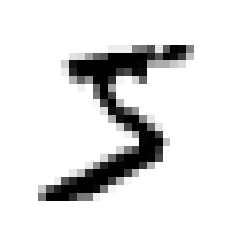

In [8]:
#take a look at one of the images
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape( 28, 28 )

plt.imshow( some_digit_image, cmap = "binary" )
plt.axis( 'off' )
plt.show()

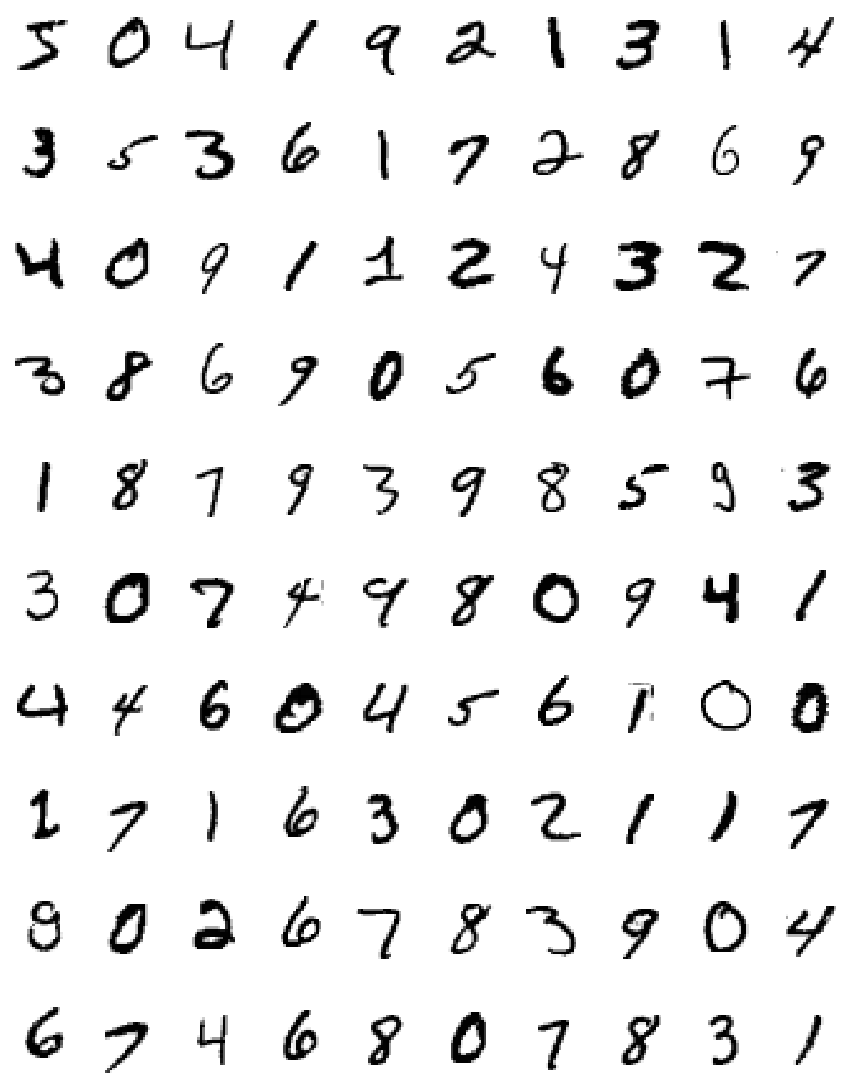

In [26]:
fig = plt.subplots(figsize=(15, 20))
    #plt.subplots_adjust( hspace = 0.1 )
    
a = 10  # number of rows
b = 10  # number of columns

for character in range(0,100):
    some_digit = X[character]
    plt.subplot( a,b,character + 1 )
    some_digit_image = some_digit.reshape( 28, 28 )
    plt.imshow( some_digit_image, cmap = "binary" )
    plt.axis( 'off' )


In [35]:
#print some labels
y = y.astype( np.uint8 )
y[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [36]:
# train/test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<br> 

### training a binary classifier

<br>

In [37]:
#a binary (T/F) classifier to identify whether a digit if a 5 (T) or not a 5 (F)
y_train_5 = ( y_train == 5 )
y_test_5 = ( y_test == 5 ) 

In [89]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier( random_state = 42 )
sgd_clf.fit( X_train, y_train_5 )

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
# use the classifier to detect the number 5
sgd_clf.predict( some_digit.reshape(1, -1) )

array([False])

In [51]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold( n_splits = 3, shuffle = True )

for train_index, test_index in skfolds.split( X_train, y_train_5 ):
    clone_clf = clone( sgd_clf )
    X_train_folds = X_train[ train_index ]
    y_train_folds = y_train_5[ train_index ]
    X_test_fold = X_train[ test_index ]
    y_test_fold = y_train_5[ test_index ]
    
    clone_clf.fit( X_train_folds, y_train_folds )
    y_pred = clone_clf.predict( X_test_fold )
    n_correct = sum( y_pred == y_test_fold )
    print( n_correct/len( y_pred ) )

0.9587
0.93915
0.9659


In [50]:
# use sklearn's cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score( sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy' )

array([0.95035, 0.96035, 0.9604 ])

In [53]:
# compare our model's accuracy to a baseline model that categorizes everything as False
from sklearn.base import BaseEstimator

class Never5Classifier( BaseEstimator ):
    def fit( self, X, y = None ):
        return self
    def predict( self, X ):
        return np.zeros( (len(X),1), dtype=bool )

In [55]:
# evaluate the baseline classifier
never_5_clf = Never5Classifier()
cross_val_score( never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy' )

array([0.91125, 0.90855, 0.90915])

<br>

Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets

<br>

In [58]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict( sgd_clf, X_train, y_train_5, cv=3 )
confusion_matrix( y_train_5, y_train_pred )

array([[53892,   687],
       [ 1891,  3530]])

<br>

|                   | **Predicted non-5s** | **Predicted 5s** |
|-------------------|----------------------|------------------|
| **Actual non-5s** | True Negatives       | False Positives  |
| **Actual 5s**     | False Negatives      | True Positives   |


* **Precision** - accuracy of the positive predictions 
    - $\mbox{precision} = \frac{TP}{TP + FP}$
* **Recall/Sensitivity** - ratio of positive instances that are correctly detected by the classifier
    - $\mbox{sensitivity} = \frac{TP}{TP + FN}$

<br>

In [60]:
#sklearn functions to find precision and recall
from sklearn.metrics import precision_score, recall_score
print( precision_score( y_train_5, y_train_pred ) )
print( recall_score( y_train_5, y_train_pred ) )

0.8370879772350012
0.6511713705958311


<br>

interpretation:  

* when the 5-detector classifies an image as a 5, it is correct ~83% of the time
* The 5-detector only detects 65% of all 5s

**F1-score, harmonic mean** the harmonic mean gives much more weight to low values and only gives high F1-scores when both precision and recall are high
$F_1 = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 * \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$  

**Precision/Recall trade-off** - increasing precision reduces recall and vice versa

<br>

In [61]:
# sklearn F1 
from sklearn.metrics import f1_score
f1_score( y_train_5, y_train_pred )

0.7325171197343846

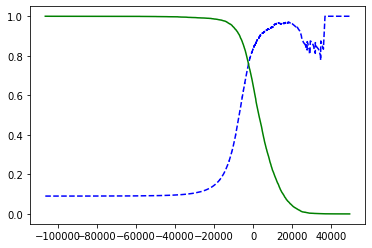

In [65]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict( sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")
precisions, recalls, thresholds = precision_recall_curve( y_train_5, y_scores )

def plot_precision_recall_vs_threshold( precisions, recalls, thresholds ):
    plt.plot( thresholds, precisions[:-1], "b--", label="precision" )
    plt.plot( thresholds, recalls[:-1], "g-", label = "recall" )
    
plot_precision_recall_vs_threshold( precisions, recalls, thresholds )
plt.show()

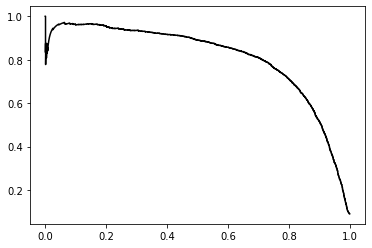

In [66]:
plt.plot( recalls[:-1], precisions[:-1] , "k-")

<br>

### ROC curve

**reciever operating characteristic curve** - plots true positive rate * False positive rate, or sensitivity * 1-specificity  
**area under the curve (AUC)** - one way to compare classifiers is by the AUC. A perfect classifier will have an ROC AUC == 1, whereas a completely random binary classifier will have an ROC AUC == 0.5.  

<br>

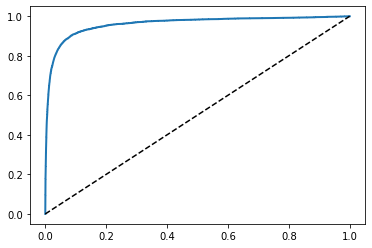

In [69]:
#plot the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve( y_train_5, y_scores )
def plot_roc_curve( fpr, tpr, label = None ):
    plt.plot( fpr, tpr, linewidth = 2, label = label )
    plt.plot( [0,1], [0,1], 'k--')
    
plot_roc_curve( fpr, tpr )
plt.show()

In [70]:
#find the AUC
from sklearn.metrics import roc_auc_score
roc_auc_score( y_train_5, y_scores )

0.9604938554008616

In [72]:
# train a random forest classifier and compare the ROC/AUC with the SGD classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier( random_state = 42 )
y_probas_forest = cross_val_predict( forest_clf, X_train, y_train_5, cv=3, method= "predict_proba" )

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve( y_train_5, y_scores_forest )

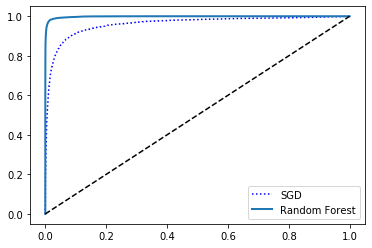

In [75]:
plt.plot( fpr, tpr, "b:", label = 'SGD')
plot_roc_curve( fpr_forest, tpr_forest, label = "Random Forest")
plt.legend( loc = "lower right" )
plt.show()

In [76]:
roc_auc_score( y_train_5, y_scores_forest )

0.9983436731328145

<br>

### Multiclass Classification

* **one-vs-all/rest (OvR)** - train binary classifiers for each class, get decision scores from each classifier and return the class that corresponds to the best value
* **one-vs-one (OvO)** - need $N \cdot (N-1) /2$ classifiers to distinguish between pairs of classes. chose the winner of most comarisons.

<br>

In [78]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit( X_train, y_train )
svm_clf.predict( [ some_digit ] )

array([1], dtype=uint8)

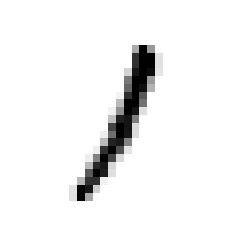

In [79]:
some_digit_image = some_digit.reshape( 28, 28 )

plt.imshow( some_digit_image, cmap = "binary" )
plt.axis( 'off' )
plt.show()

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])
print( some_digit_scores )
print( np.argmax( some_digit_scores ) )
print( svm_clf.classes_ )

[[-0.30727308  9.31003099  6.22374339  3.09511851  6.15897488  1.71471474
   0.69542629  8.29964841  4.12604772  6.22776651]]
1
[0 1 2 3 4 5 6 7 8 9]


In [82]:
# specify OvR
from sklearn.multiclass import OneVsRestClassifier
some_digit = X[36]
ovr_clf = OneVsRestClassifier( SVC() )
ovr_clf.fit( X_train, y_train )

NameError: name 'somedigit' is not defined

In [83]:
ovr_clf.predict([some_digit])

array([6], dtype=uint8)

In [91]:
#can also train the SDGClassifier
#sdg_clf = 
sgd_clf.fit( X_train, y_train )
sgd_clf.predict([some_digit])

array([6], dtype=uint8)

In [92]:
sgd_clf.decision_function([some_digit])

array([[-55723.18404806, -20277.71791818,  -3736.27195493,
         -8007.95082389, -13861.24096739,  -8747.27028356,
          5032.8587293 , -44464.31319087,  -1145.95291205,
        -15732.06327288]])

In [93]:
cross_val_score( sgd_clf, X_train, y_train, cv=3, scoring='accuracy' )

array([0.87365, 0.85835, 0.8689 ])

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform( X_train.astype( np.float64 ) )
cross_val_score( sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy' )

array([0.8983, 0.891 , 0.9018])

<br>

### Error Analysis

what types of error does the model make?

<br>

In [96]:
y_train_pred = cross_val_predict( sgd_clf, X_train, y_train, cv = 3 )
conf_mx = confusion_matrix( y_train, y_train_pred )
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

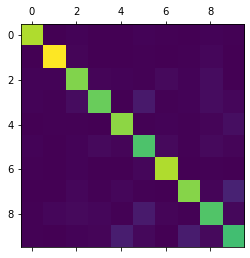

In [97]:
plt.matshow( conf_mx )
plt.show()

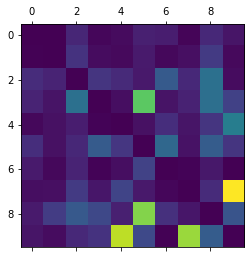

In [98]:
#focus on just the errors
row_sums = conf_mx.sum( axis = 1, keepdims = True )
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal( norm_conf_mx, 0)
plt.matshow( norm_conf_mx )
plt.show()

<br>

3s and 5s get mixed up.  
4s and 9s get mixed up.  
7s and 9s get mixed up.  
many numbers seem to get misclassified as 8, but 8s generally get correctly classified

<br>

In [99]:
# visualize some of the 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[ (y_train == cl_a ) & (y_train_pred == cl_a)]
X_ab = X_train[ (y_train == cl_a ) & (y_train_pred == cl_b)]
X_ba = X_train[ (y_train == cl_b ) & (y_train_pred == cl_a)]
X_bb = X_train[ (y_train == cl_b ) & (y_train_pred == cl_b)]

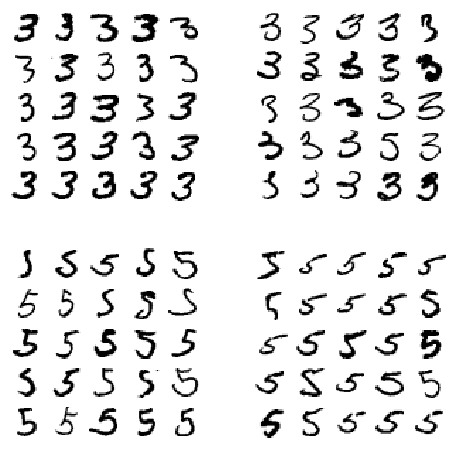

In [103]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure( figsize = (8,8) )
plt.subplot(221); plot_digits( X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits( X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits( X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits( X_bb[:25], images_per_row=5)

<br>

### Multilabel Classification

<br>

In [104]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = ( y_train >= 7 )
y_train_odd = ( y_train % 2 == 1 )
y_multilabel = np.c_[ y_train_large, y_train_odd ]

knn_clf = KNeighborsClassifier()
knn_clf.fit( X_train, y_multilabel )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [105]:
knn_clf.predict([some_digit])

array([[False, False]])

In [107]:
y_train_knn_pred = cross_val_predict( knn_clf, X_train, y_multilabel, cv = 3 )
f1_score( y_multilabel, y_train_knn_pred, average='macro')

KeyboardInterrupt: 

In [ ]:
f1_score( y_multilabel, y_train_knn_pred, average='weighted')

<br>

## Chapter 4: Training Models

<br>

In many situations, you don't need to know the implementation details  
However, having a good understanding oh how things work can help you quickly home in on the appropriate model, the right training algorithm to use and a good set of hyperparameters for your task  

* **closed-form** - directly compute model parameters that best fit the model to the training set
* **iterative optimization** - gradually tweak model parameters to minimize the cost function over the training set  

### Linear Regression

training a model means setting its parameters so that the model best fits the training set. (ex: for Linear Regression: find the value that minimizes the RMSE, or in practice the MSE)  
$$\mbox{MSE}(\mathbf{X},h_{\theta}) = \frac{1}{m} \sum^m_{i=1}(\mathbf{\theta}^T \mathbf{x}^{(i)}-y^{(i)})^2$$

**closed-form** solution: *Normal Equation* $\hat{ \mathbf{ \theta }} = (\mathbf{X}^T \mathbf{X})^{-1} \cdot \mathbf{X}^T \mathbf{y}$

<br>

In [17]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.randn( 100, 1 )
y = 4 + 3 * X + np.random.randn( 100, 1 )

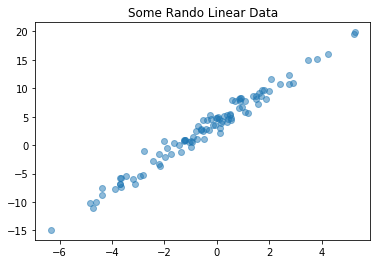

In [18]:
plt.scatter(X, y, alpha=0.5)
plt.title( "Some Rando Linear Data")
plt.show()

In [19]:
# compute theta_hat using the Normal Equation
X_b = np.c_[ np.ones((100,1)),X]
theta_best = np.linalg.inv( X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.09438671],
       [2.9296006 ]])

In [20]:
#make predictions using theta_hat
X_new = np.array( [[0],[2]] )
X_new_b = np.c_[ np.ones((2,1)), X_new ]
y_predict = X_new_b.dot( theta_best )
y_predict

array([[4.09438671],
       [9.9535879 ]])

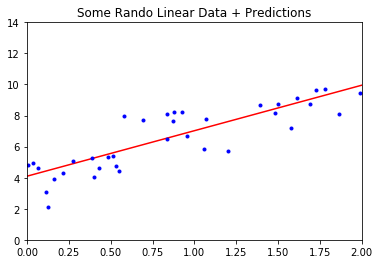

In [22]:
plt.plot( X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data + Predictions")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )
plt.show()

In [23]:
# performing linear regression is simple with sklearn:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit( X, y )
print( lin_reg.intercept_, lin_reg.coef_ )
lin_reg.predict( X_new )

[4.09438671] [[2.9296006]]


array([[4.09438671],
       [9.9535879 ]])

<br>

**gradiant descent** - tweak parameters iteratively in order to minimize a cost function. GD measures the local gradient of the error functionwith regard to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum (convergence).  

**learning rate** - the size of the steps that the gradient descent takes while tweaking parameters. learning rate is a **hyperparameter**. Training a model means searching for a combinations of model parameters (hyperpaprameters) that minimizes a cost function  

when using gradient descent, you should ensure that all features have a similar scale, or else it will take much longer to converge.  

**partial derivative** - caluclate how much the value (cost function) changes if you change $\theta$ just a little bit  

partial derivative of the cost function: $$\frac{\partial}{\partial \theta_j}\mbox{MSE}(\mathbf{\theta}) = \frac{2}{m}\sum^m_{i=1}(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)})x_j^{(i)} $$

**batch gradient descent** - calculattions over the full training set at each gradient descent step

<br>

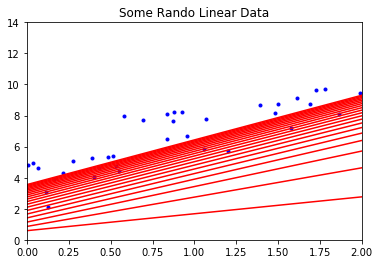

In [32]:
# implement batch gradient descent
eta = 0.1 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

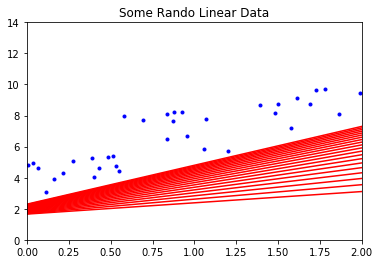

In [33]:
# implement batch gradient descent
eta = 0.02 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

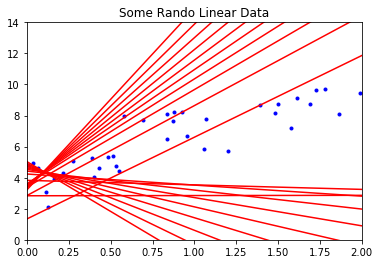

In [34]:
# implement batch gradient descent
eta = 0.4 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

<br>

**stochastic gradient descent** - picks a random instance in the training set at every step and computes the gradients based only on a single instance  

shuffle the data to ensure that the training instances are independent, otherwise SGD might not converge on the global minimum

<br>

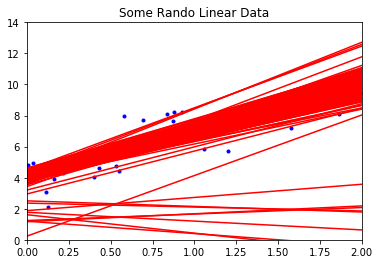

In [35]:
plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data + Stochastic Gradient Descent")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


n_epochs = 50
t0, t1 = 5, 50

def learning_schedule( t ):
    return t0 / ( t + t1 )

theta = np.random.randn( 2,1 )

for epoch in range( n_epochs ):
    for i in range( m ):
        random_index = np.random.randint( m )
        xi = X_b[ random_index : random_index + 1 ]
        yi = y[ random_index : random_index + 1 ]
        gradients = 2 * xi.T.dot( xi.dot( theta ) - yi )
        eta = learning_schedule( epoch * m + i )
        theta = theta - eta * gradients
        y_predict = X_new_b.dot( theta )
        plt.plot( X_new, y_predict, "r-")
        
plt.show()

In [37]:
#stochastic gradient descent by sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor( max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1 )
sgd_reg.fit( X, y.ravel() )
print( sgd_reg.intercept_, sgd_reg.coef_ )

[3.98008106] [2.94971262]


<br>

**mini-batch gradient descent** - compute the gradients on small random sets of instances called mini-batches  

Comparison of some algorithms used for Linear Regression:  

| **Algorithm**           | **Large m** | **Out-of-core support** | **Large n** | **Hyperparameters** | **Scaling required** | **Scikit-Learn** |
|-------------------------|-------------|-------------------------|-------------|---------------------|----------------------|------------------|
| **Normal Equation**     |     Fast    |            No           |     Slow    |          0          |          No          |        N/A       |
| **Singular Val Decomp** |     Fast    |            No           |     Skow    |          0          |          No          | LinearRegression |
| **Batch GD**            |     Slow    |            No           |     Fast    |          2          |          Yes         |   SGDRegressor   |
| **Stochastic GD**       |     Fast    |           Yes           |     Fast    |        $\ge$2       |          Yes         |   SGDRegressor   |
| **Mini-Batch GD**       |     Fast    |           Yes           |     Fast    |        $\ge$2       |          Yes         |   SGDRegressor   |

<br>

### Polynomial Regression

you can use a linear model to fit nonlinear data

<br>

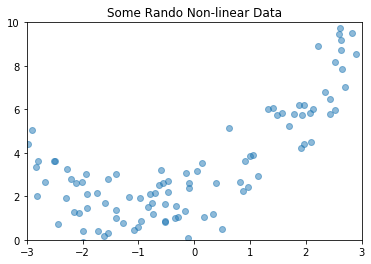

In [40]:
# generate some quadratic nonlinear data
m = 100
X = 6 * np.random.rand( m, 1 ) - 3 
y = 0.5 * X**2 + X + 2 + np.random.randn( m,1 )

plt.scatter(X, y, alpha=0.5)
plt.title( "Some Rando Non-linear Data")
plt.xlim( -3, 3 )
plt.ylim( 0, 10 )
plt.show()

<br>

add the square of each feature in the training set as a new feature. then, fit a `LinearRegression` model

<br>

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures( degree = 2, include_bias = False )
X_poly = poly_features.fit_transform( X )

lin_reg = LinearRegression()
lin_reg.fit( X_poly, y )
print( lin_reg.intercept_, lin_reg.coef_ )

[1.92915937] [[1.02768411 0.50995224]]


In [52]:
y_predict = lin_reg.predict( X_poly )

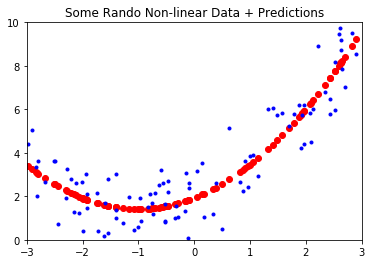

In [55]:
plt.plot( X,y_predict, "ro")
plt.plot(X, y, "b.")
plt.title( "Some Rando Non-linear Data + Predictions")
plt.xlim( -3, 3 )
plt.ylim( 0, 10 )
plt.show()

<br>

In general, you won't know the function that generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?  

**learning curves** - plots of the model's performance on the training set and the validation set as a function of the training set size

<br>

In [58]:
# learning curve for LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves( model, X, y ):
    X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2 )
    train_errors, val_errors = [], []
    for m in range( 1, len( X_train ) ):
        model.fit( X_train[ :m ], y_train[ :m ] )
        y_train_predict = model.predict( X_train[ :m ] )
        y_val_predict = model.predict( X_val )
        train_errors.append( mean_squared_error( y_train[ :m ], y_train_predict ) )
        val_errors.append( mean_squared_error( y_val, y_val_predict ) )
    plt.plot( np.sqrt( train_errors ), 'r-+', linewidth=2, label='train' )
    plt.plot( np.sqrt( val_errors ), 'b-', linewidth=2, label='val' )

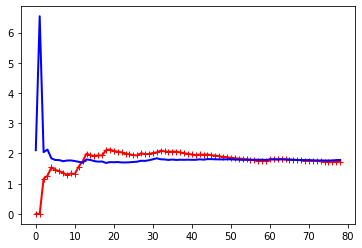

In [59]:
lin_reg = LinearRegression()
plot_learning_curves( lin_reg, X, y )

<br>

the above curves are typical of a model that is underfitting: both curves have reached a plateau, they are close and fairly high. If your model is underfitting the training data, adding more training exambles will not help. You need to use a more complex model or come up with better features.  

<br>

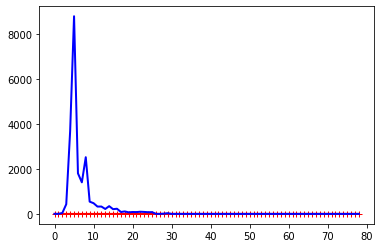

In [63]:
# look at the learning curves of a 10 deg polynomial
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline( [
    ("poly_features", PolynomialFeatures( degree=10, include_bias = False ) ),
    ("lin_reg", LinearRegression() ),
])

plot_learning_curves( polynomial_regression, X, y )

<br>

notice that the error on the training data is a lot lower than it was for LinearRegression. there is also a big gap between the performance on the training data and on the validation data.  

one way to improve an overfitting model is to feed it more training data until the validation error reaches the training error  

<br>

**Bias/Variance Trade-Off**  

a model's generalization error can be expressed as the sum of three very different errors:  

1. **Bias** - due to wrongness of assumptions (e.g assuming a linear model). will most likely underfit
2. **Variance** - due to the model's excessive sensitivity to variations in the training data. will likely overfit
3. **Irreducible Error** - due to noise inherent in the data  

increasing a model's complexity will typically increase it's variance and reduce it's bias. Conversely, reducing a model's complexity increases it's bias and reduces it's variance.  

<br>

### Regularized Linear Models

constrain the weights of the model such that the model has fewer degrees of freedom  

**Ridge Regression** - a regularization term is added to the cost function which froces the learning algorithm to not only fit the data, but also keep the model weights as small as possible.  
$$\mbox{J}(\theta) = \mbox{MSE}(\theta) + \alpha \frac{1}{2} \sum_{i=1}^n \theta_i^2$$

it is important to scale the data ( e.g. with `StandardScaler` ) before performing Ridge Regression, as it is sensitive to the scale of the input features

<br>

In [64]:
#ridge regression using scikit-learnclosed-form:
from sklearn.linear_model import Ridge
ridge_reg = Ridge( alpha = 1, solver = 'cholesky' )
ridge_reg.fit( X,y )
ridge_reg.predict([[1.5]])

array([[5.0808239]])

In [68]:
#ridge regression by way of stochastic gradient descent:
sgd_ridge = SGDRegressor( penalty = 'l2' ) #add a regilarization term
sgd_ridge.fit( X, y.ravel() )
sgd_ridge.predict([[1.5]])

array([5.06731112])

<br>

**lasso regression** - Least Absolute Shrinkage and Selection Operator Regression. adds a regularization term to the cost function, but it uses the $\mathcal{l}_1$ norm of the weught vector instead of half the square of the $\mathcal{l}_2$ norm $$\mbox{J}(\theta) = \mbox{MSE}(\theta) + \alpha \sum_{i=1}^n |\theta_i|$$

tends to eliminate the weights of the least important features $\longrightarrow$ Lasso Regression automatically performs feature selection and outputs a sparse model

<br>

In [67]:
# a small Lasso Regression example with scikit-learn
from sklearn.linear_model import Lasso
lasso_reg = Lasso( alpha = 0.1 )
lasso_reg.fit( X,y )
lasso_reg.predict([[1.5]])

array([5.03318065])

In [69]:
#lasso regression by way of stochastic gradient descent:
sgd_lasso = SGDRegressor( penalty = 'l1' ) #add a regilarization term
sgd_lasso.fit( X, y.ravel() )
sgd_lasso.predict([[1.5]])

array([5.05539776])

<br>

**Elastic Net** - the regularization term is a simple mix of both Ridge and Lasso that is controlled by a mic ratio *r*: $$\mbox{J}(\theta) = \mbox{MSE}(\theta) + r\alpha \sum_{i=1}^n |\theta_i| + \alpha \frac{1-r}{2} \sum_{i=1}^n \theta_i^2$$

So when should you use plain Linear Regression (w/o regularization), Ridge, Lasso, or Elastic Net?: it is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features' weights down to zero. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

<br>

In [70]:
#elastic net short example:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet( alpha=0.1, l1_ratio = 0.5 )
elastic_net.fit( X,y )
elastic_net.predict([[1.5]])

array([5.03213402])

<br>

**Early Stopping** - stop training as soon as the validation error reaches a minimum.  ....a "beautiful free lunch" (-Geoffrey Hinton)  

<br>

In [83]:
#basic early stopping implementation:

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prepare the data
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2 )
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures( degree = 90, include_bias = False ) ),
    ("std_scaler", StandardScaler() )
])

X_train_poly_scaled = poly_scaler.fit_transform( X_train )
X_val_poly_scaled = poly_scaler.transform( X_val )

sgd_reg = SGDRegressor( max_iter = 1, tol = -np.infty, warm_start = True,
                       penalty = None, learning_rate = 'constant', eta0 = 0.0005 )

minimum_val_error = float( "inf" )
best_epoch = None
best_model = None

for epoch in range( 1000 ):
    sgd_reg.fit( X_train_poly_scaled, y_train.ravel() )
    y_val_predict = sgd_reg.predict( X_val_poly_scaled )
    val_error = mean_squared_error( y_val, y_val_predict )
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone( sgd_reg )

In [84]:
print( str( best_epoch ) )
print( str( best_model ) )
print( str( minimum_val_error ) )

30
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)
3.9799252818280118


<br>

### Logistic Regression

**logistic (logit) regression** - used to estimate the probability that an instance belongs to a particular class
$$\hat{p} = h_{\theta}($\mathbf{x}) = \sigma ($\mathbf{x}^T $\mathbf{\Theta}$$

the logistic function, $\sigma()$ is a sigmoid function that outputs a number between 0 and 1
$$\sigma(t) = \frac{1}{1+\mbox{exp}(-t)}$$

once an estimate is made, a class prediction is determined as follows:
$$\hat{y} = \left\{ \begin{array}{rcl}
0 & \mbox{if}
& \hat{p} \lt 0.5 \\ 1 & \mbox{if} & \hat{p}\ge 0.5 
\end{array}\right.$$

cost function:
$$c(\Theta) = \left\{ \begin{array}{rcl}
-\mbox{log} (\hat{p}) & \mbox{if}
& y = 1 \\ -\mbox{log}(1-\hat{p}) & \mbox{if} & y = 0 
\end{array}\right.$$

**log-loss** - the cost function over the whole training set is the average cost over the training instances

<br>

In [87]:
# logistic regression for classification with the iris data set
from sklearn import datasets
iris = datasets.load_iris()
list( iris.keys() )
X = iris['data'][:,3].reshape(-1, 1)
y = ( iris['target']==2 ).astype( np.int )

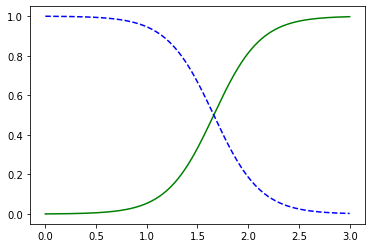

In [88]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit( X,y )

X_new = np.linspace( 0,3,1000 ).reshape( -1,1 )
y_proba = log_reg.predict_proba( X_new )
plt.plot( X_new, y_proba[:,1], 'g-', label = 'Iris virginica' )
plt.plot( X_new, y_proba[:,0], 'b--', label = 'Not Iris virginica' )

<br>

**Softmax | Multinomial Logistic Regression** - a generalized form of logistic regression that can support multiple classes.

<br>

In [90]:
X = iris['data'][:,(2,3)]
y = iris['target']

softmax_reg = LogisticRegression( multi_class = 'multinomial', solver = 'lbfgs', C=10 )
softmax_reg.fit( X,y )
print( softmax_reg.predict([[ 5,2 ]]) )
softmax_reg.predict_proba([[5,2]])

[2]


array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

<br>

## Chapter 5: Support Vector Machines

<br>

### Linear SVM Classification

**large margin classification** - fits the widest possible interval between classes  
**support vectors** - the instances on the margin (edge of the street)  
**hard-margin classification** - all class instances must be 'off the street' and on the right side of their respective support vector  
**soft-margin classification** - more flexible approach that allows margin violations. strives to find a balance between keeping the street as large as possible.  
if an `sklearn` SVM model is overfitting, can try to regularize it by reducing the `C` parameter  

<br>

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris[ 'data' ][ :, (2,3) ]
y = ( iris[ 'target' ] == 2 ).astype( np.float64 )

svm_clf = Pipeline( [
    ( 'scaler', StandardScaler() ),
    ( 'linear_svc', LinearSVC( C=1, loss = 'hinge' ) ), #could also use SVC(kernal='linear',C=1),
                                                        #or SGDClassifier( loss='hinge', alpha=1/(m*C))
] )

svm_clf.fit( X,y )

svm_clf.predict( [ [5.5, 1.7 ] ] )

array([1.])

<br>

### Nonlinear SVM Classification

<br>

In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X,y = make_moons( n_samples=100, noise = 0.15 )
polynomial_svm_clf = Pipeline([
    ( 'poly_features', PolynomialFeatures( degree=3 ) ),
    ( 'scaler', StandardScaler() ),
    ( 'svm_clf', LinearSVC( C = 10, loss='hinge' ) )
])

polynomial_svm_clf.fit( X,y )

/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

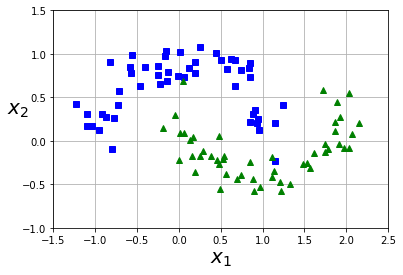

In [11]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

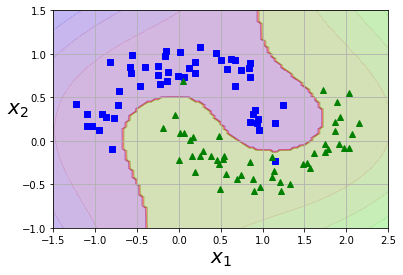

In [13]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

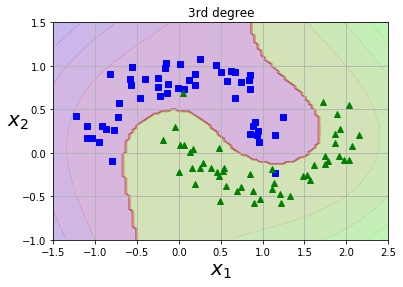

In [14]:
# train an SVM classifier using a 3rd D polynomial kernel
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ( 'scaler', StandardScaler() ),
    ( 'svm_clf', SVC( kernel = 'poly', degree = 3, coef0 = 1, C = 5 ) )
])
poly_kernel_svm_clf.fit( X,y )

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title( '3rd degree' )
plt.show()

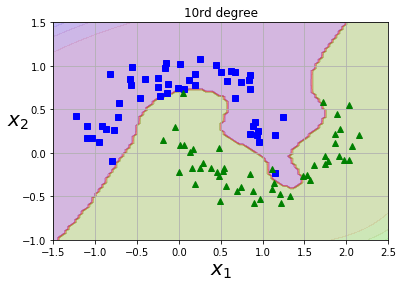

In [16]:
# train an SVM classifier using a 10th D polynomial kernel
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ( 'scaler', StandardScaler() ),
    ( 'svm_clf', SVC( kernel = 'poly', degree = 10, coef0 = 1, C = 5 ) )
])
poly_kernel_svm_clf.fit( X,y )

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title( '10rd degree' )
plt.show()

<br>

A common approach to finding the right parameters (such as the polynomial degree) is with grid search. can start course and refine search close to optimal paramters

<br>

**Similarity Features** - add features computed using a similarity funtion to landmarks in the data. ex:  use a gaussian Radial Basis Function to give a measure that quantifies the distnace from a certain landmark for your data  

$$\phi_y(\mathbf{x},l)=\mbox{exp}(-y\|\mathbf{x}-l\|^2)$$

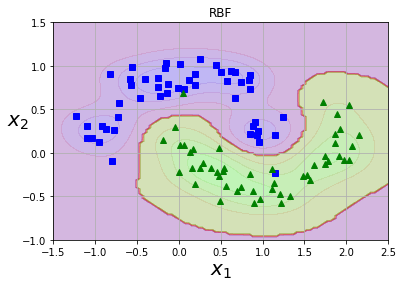

In [17]:
# SVC class with a Gaussian RBF kernel
rbf_kernel_svm_clf = Pipeline([
    ( 'scaler', StandardScaler() ),
    ( 'svm_clf', SVC( kernel = 'rbf', gamma = 5, C = 0.001 ) )
])
rbf_kernel_svm_clf.fit( X,y )

plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title( 'RBF' )
plt.show()

<br>

What to do?:  

* start off with a linear kernel
* next try a Gaussian RBF
* if you have time to spare: try other kernals especially if there is something specialized for the data structure being analyzed

<br>

### SVM Regression

instead of trying to create the widest street margin between classes (as in SVM classification), SVM regression aims to fit as many instances as possible within the bounds of the support vectors. the width of the street is controlled by the hyperparameter $\varepsilon$

<br>

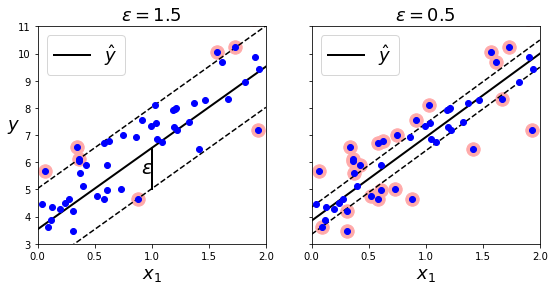

In [22]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

# scikit-learn's LinearSVR class
from sklearn.svm import LinearSVR
svm_reg = LinearSVR( epsilon=1.5 )
svm_reg.fit( X,y )


svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])


def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)


plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

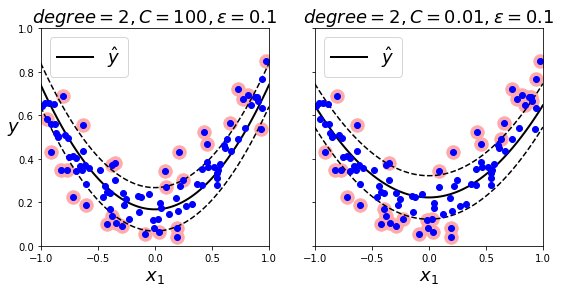

In [24]:
# can be just as easily implemented with nonlinear
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()


from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)


fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

<br>

### Under the Hood 

**decision boundary** - the set of points where the deicision function = 0; intersection of the decision function plane and the plane described by the data  
training a linear SVM classifier means finding the values of **w** and *b* that make this margin as wide as possible while avoiding margin violations or limiting them.  

Common Kernels:  

|    **Kernel**    |  °º¤ø,¸¸,ø¤º°`°º¤ø,¸,ø¤°º¤ø,¸¸,ø¤º°`°º¤ø,¸**Expression**°º¤ø,¸¸,ø¤º°`°º¤ø,¸,ø¤°º¤ø,¸¸,ø¤º°`°º¤ø,¸            |
|:----------------:|:--------------------------------------------------------------------------------------:|
| **Linear**       | $\mbox{K}(\mathbf{a},\mathbf{b})=\mathbf{a}^T\mathbf{b}$                             |
| **Polynomial**   |         $\mbox{K}(\mathbf{a},\mathbf{b})=(\gamma\mathbf{a}^T\mathbf{b}+r)^d$         |
| **Gaussian RBF** | $\mbox{K}(\mathbf{a},\mathbf{b})=\mbox{exp}(-\gamma \| \mathbf{a} - \mathbf{b} \|^2$ |
| **Sigmoid**      | $\mbox{K}(\mathbf{a},\mathbf{b})=\mbox{tanh} (\gamma \mathbf{a}^T\mathbf{b} + r)$    |

<br>

<br>

## Chapter 6: Decision Trees

<br>

In [2]:
# train a decision tree classifier
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[ :,2: ]
y = iris.target

tree_clf = DecisionTreeClassifier( max_depth = 2 )
tree_clf.fit( X,y )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

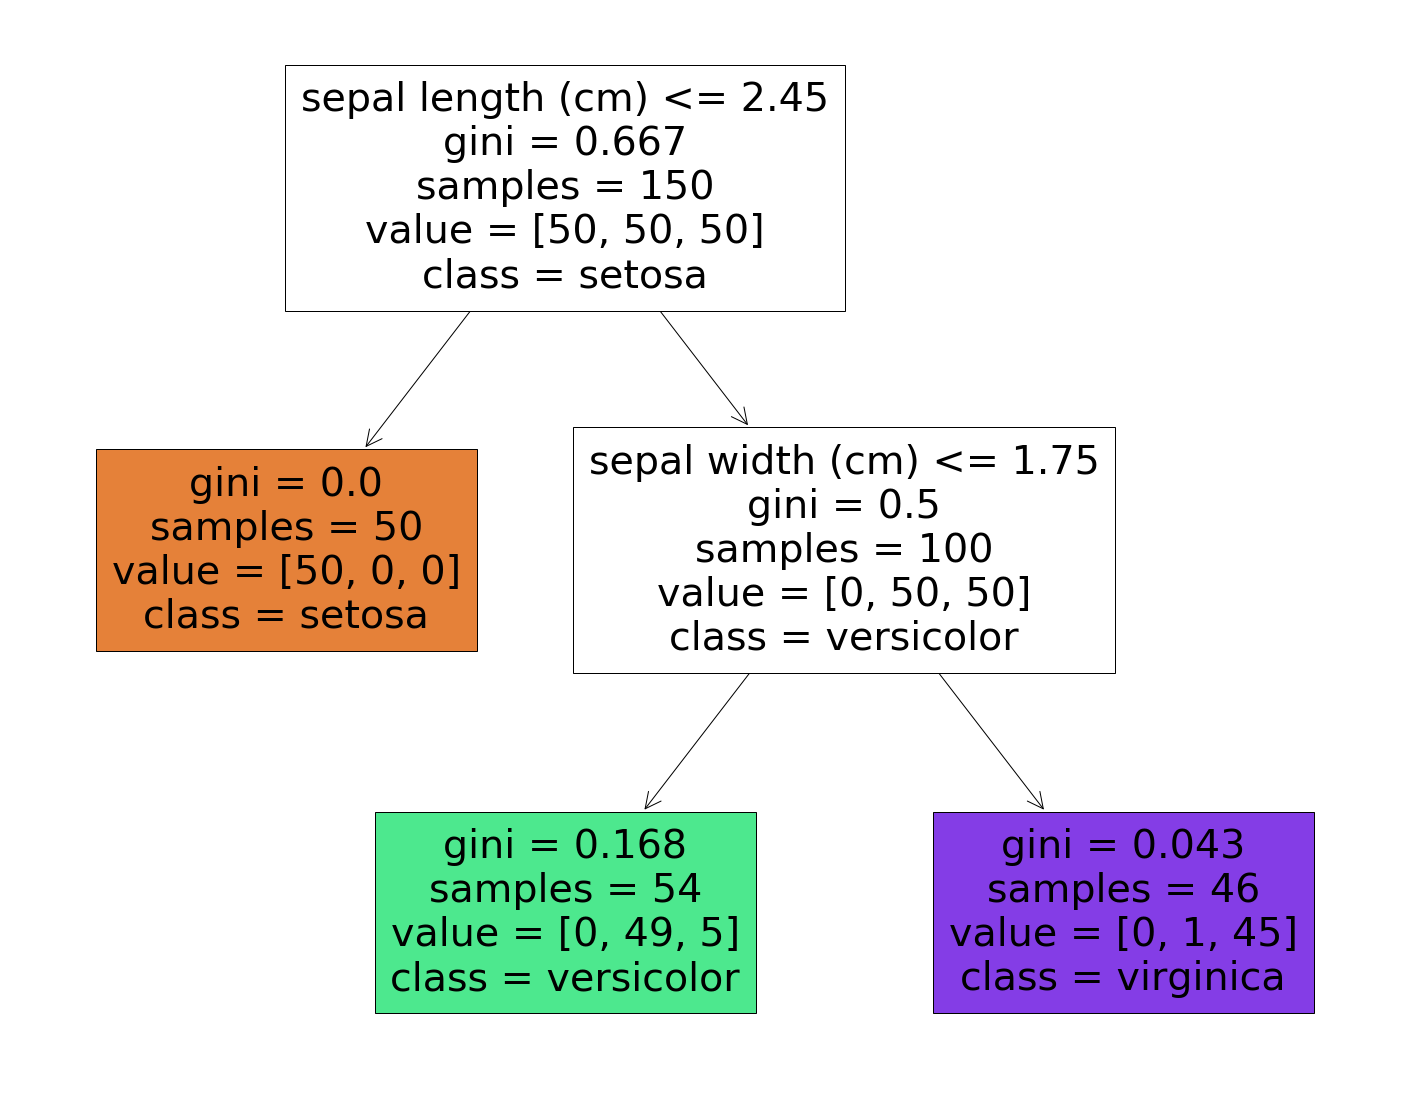

In [4]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(tree_clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

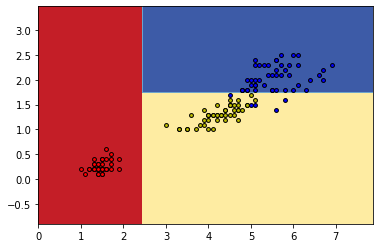

In [11]:
# Plot the decision boundary

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=15)


<br>

### Estimating class probabilities

<br>

In [12]:
new_data = [[5,1.5]]
print( tree_clf.predict_proba( new_data ) )
tree_clf.predict( new_data )

[[0.         0.90740741 0.09259259]]


array([1])

<br>

**CART Training Algorithm** - Classification and Regression Tree algorithm: search for a feature that produces the purest subsets for a given threshold. then split subsets on the same logic untill a maximum depth is reached or no more splits can be found to increase purity. CART is a greedy algorithm: it greedily searches for the optimal split at the top level irrespective of lowest possible purity at subsequent levels. Therefore, CART finds a reasonably good solution, but not necessarily the optimal solution.  

**Regularization** - to avoid overfitting the training data, you need to restict the Decision Tree's freedom during training.  Ex: reducing the `max_depth` parameter will regularize the model and thus reduce the risk of overfitting

<br>

### Regression

The most noticable difference is that instead of predicting a class, the regression returns a predicted value

<br>

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor( max_depth = 2 )
tree_reg.fit( X,y )

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

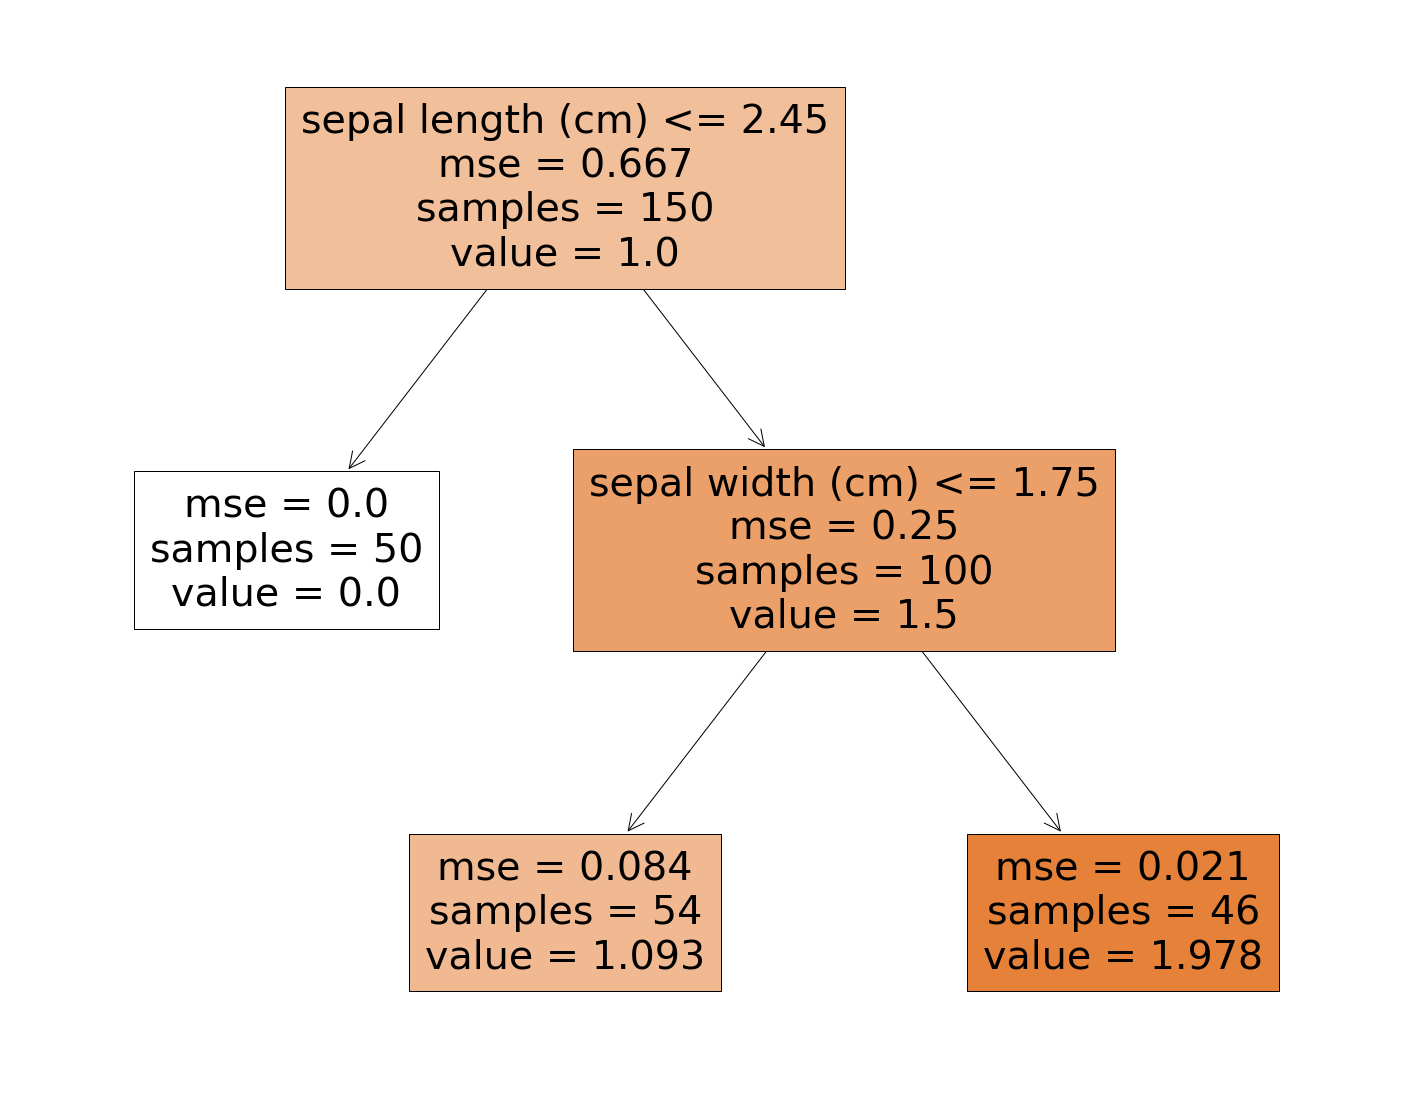

In [14]:
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(tree_reg, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

<br>

## Chapter 7: Ensemble Learning and Random Forests

**ensemble methods** - by aggregating a group of predictors, you will often get better predictions than with the best individual predictor  

**majority vote classifier** - aggregate the predictions of each classifier and predict the class that gets the most votes  

ensemble methods work best when the predictors are as independent fro one another as possible. One way to get diverse classifiers is to train them using different algorithms. This increases the chance that they will make very different types of errors, improving the ensembles accuracy

<br>

In [2]:
# Voting Classifiers
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
rnd_clf  = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier( estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc',svm_clf)],
                             voting='hard' )
voting_clf.fit( X_train, y_train )

for clf in (log_clf, rnd_clf, svm_clf, voting_clf ):
    clf.fit( X_train, y_train )
    y_pred = clf.predict( X_test )
    print( clf.__class__.__name__, accuracy_score( y_test, y_pred ) )

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


<br>

The voting classifier slightly outperforms all the individual classifiers  

**hard voting** - majority vote classifier  
**soft voting** - predict the class with the highest probability averaged over all classifiers

<br>

In [6]:
#hard voting approach
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier( estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc',svm_clf)],
                             voting='soft' )
voting_clf.fit( X_train, y_train )

for clf in (log_clf, rnd_clf, svm_clf, voting_clf ):
    clf.fit( X_train, y_train )
    y_pred = clf.predict( X_test )
    print( clf.__class__.__name__, accuracy_score( y_test, y_pred ) )

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.912


<br>

Notice that the voting classifier achieves a higher accuracy with soft voting

<br>

### Bagging & Pasting 

instead of using very different trainning algorithms...  
**bagging** - use the same training algorithm on different subsets of the training data and perform **with** replacement (bootstrapping)  
**pasting** - use the same training algorithm on different subsets of the training data and perform **without** replacement  

<br>

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier( DecisionTreeClassifier(),
                           n_estimators=500,
                           max_samples=100,
                           bootstrap=True,
                           n_jobs=-1)
bag_clf.fit( X_train, y_train )
y_pred = bag_clf.predict( X_test )

In [8]:
print( 'bagging clf:')
print( accuracy_score( y_test, y_pred ) )

tree_clf = DecisionTreeClassifier()
tree_clf.fit( X_train, y_train )
y_pred_tree = tree_clf.predict( X_test )
print( 'decision tree clf:' )
print( accuracy_score( y_test, y_pred_tree ) )

bagging clf:
0.912
decision tree clf:
0.872


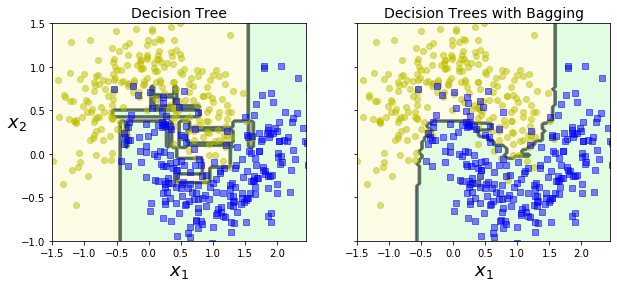

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()    

<br>

bagging results in a more accurate prediction than the decision tree. furthermore, the decision bundary formed by the bagging ensemble of trees generalizes (is smoother) a lot more than a single decision tree's boundary.

<br>

**out-of-bag evaluation** - can evaluate the ensemble on the instances that were not sampled by setting `oob_score`=True  

<br>

In [11]:
bag_clf = BaggingClassifier( DecisionTreeClassifier(),
                           n_estimators=500,
                           bootstrap=True,
                           n_jobs=-1,
                           oob_score=True )
bag_clf.fit( X_train, y_train )
bag_clf.oob_score_

0.904

<br>

### Random Forests

**random forest** - is an ensemble of decision trees.

<br>

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier( n_estimators=500,
                                max_leaf_nodes=16,
                                n_jobs=-1 )
rnd_clf.fit( X_train, y_train )

y_pred_rf = rnd_clf.predict( X_test )

print( accuracy_score( y_test, y_pred_rf ) )

0.92


<br>

**feature importance** - how much the tree nodes that use the feature reduce the impurity on average (across all trees in the forest)

<br>

In [15]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier( n_estimators=500,
                                n_jobs=-1)
rnd_clf.fit( iris['data'], iris['target'])
for name, score in zip( iris['feature_names'], rnd_clf.feature_importances_):
    print( name, score )

sepal length (cm) 0.09589423323615767
sepal width (cm) 0.020699239164247162
petal length (cm) 0.4090602614381311
petal width (cm) 0.47434626616146414


In [16]:
#MNIST - pixel importance

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [19]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image,
               interpolation="nearest")
    plt.axis("off")

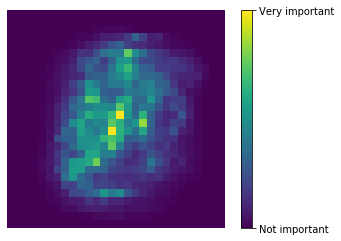

In [20]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

<br>

Random Forest is really great for performing feature selection

### Boosting

**boosting** - any ensemble method that can combine several weak learners into a strong learner

#### AdaBoost 

**Adaboost** - adaptive boosting. focusing more and more on the hard cases (the underfitted cases). increase the relative weight of the misclassified training instances. train a subsequent classifier with the updated weights and evaluate perfromance.  
**learning rate** - amount the weights are allowed to change  
**predictor weight** - $\alpha_j = \eta \mbox{log}\frac{1-r_j}{r_j}$  the more accurate the predictor is, the higher the weight. chance performance ~0. negative values if wrong more than chance.  
**instance weights** - AdaBoost algorithm updates the instance weights such that misclassified instances get a boost.  
The algorithm stopds when a desired number of predictors is reached or when a perfect predictor is found.  

#### Gradient Boosting

**gradient boosting** - fit the new predictor to the residual errors made by the previous predictor

<br>

In [21]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier( DecisionTreeClassifier( max_depth=1),
                            n_estimators=200,
                            algorithm='SAMME.R',
                            learning_rate=0.5 )
ada_clf.fit( X_train, y_train )

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [27]:
# Gradient Boost
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor( max_depth = 2 )
tree_reg1.fit( X,y )

#train a second on the residual errors made by the first predictor
y2 = y - tree_reg1.predict( X )
tree_reg2 = DecisionTreeRegressor( max_depth = 2 )
tree_reg2.fit( X, y2 )

#train a third "  "....
y3 = y2 - tree_reg2.predict( X )
tree_reg3  = DecisionTreeRegressor( max_depth=2 )
tree_reg3.fit( X, y )

#make a prediction on a new instance by adding up the predictions of all the trees
#y_pred = sum( tree.predict( X_new ) for tree in ( tree_reg1, tree_reg2, tree_reg3 ) )

# the following code has the same effect:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor( max_depth=2, n_estimators=3, learning_rate=1.0 )
gbrt.fit( X,y )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

<br>

The ensemble's predictions gradually get better as trees are added to the ensemble.  

<br>

In [ ]:
# val finding the optimal number of trees using shrinkage
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split( X,y )

gbrt = GradientBoostingRegressor( max_depth=2, n_estimators=120)
gbrt.fit( X_train, y_train )

errors = [ mean_squared_error( y_val, y_pred )
         for y_pred in gbrt.staged_predict( X_val)]
bst_n_estimators = np.argmin( errors ) + 1

gbrt_best = GradientBoostingRegressor( max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit( X_train, y_train )

<br>

can also do something like this: implement early stoppage when the validation error does not improve for 5 iterations in a row. 

<br>

## Chapter 8: Dimensionality Reduction

**curse of dimensionality**  
there's plenty of space in high dimentions. as a result, high-dimentional datasets are at risk of being very sparse. new data will likely be further from training instances...this increases the risk of overfitting with high-dimensional datasets. In practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.  

Main approaches to dimensionality reduction: 

* **projection** - in many cases, training instances are not uniformly distributed. rather, they can be described quite accurately in a lower-dimentional sub-space of the higher space. 
* **manifold learning** - model the manifold on which the training instances lie
* **manifold hypothesis** - most real-world high-dimensional data sets lie close to a much lower-dimensional manifold
* **an assumption** - the task at hand (e.g. classification) will be simpler if expressed in the lower-dimensional space of the manifold
* **however!** - the assumption does not always hold. reducing the dimensionality of a training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.  

<br>

### PCA - Principal Component Analysis

**PCA** - identifies the hyperplane that lies closest to the data , and then projects the data onto it. finds the axis that minimizes the mean squared distance between the original dataset and its projection onto a new axis. PCA identifies the axis that accounts for the most variance in the data  
**SVD** - Singular Value Decomposition - a standard matix factorization technique that can decompose the training set matrix into three matices where one contains the vectors that define all the principal components

<br>

In [3]:
X = np.array([[7, 4, 3],[4, 1, 8], [6, 3, 5], [8, 6, 1], 
              [8, 5, 7],[7, 2, 9], [5, 3, 3], [9, 5, 8], 
              [7, 4, 5], [8, 2, 2]])
# use numpy's svd() function to obtain the PCs of the training set
X_centered = X - X.mean( axis = 0 ) #PCA assumes the data is centered on the origin
U, s, Vt = np.linalg.svd( X_centered )
# extract the unit vectors that define the first two principal components
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

<br>

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to *d* dimensions by projecting onto the hyperplane defined by the first *d* principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.  

Projecting down: $\mathbf{X}_{d-proj} = \mathbf{XW}_d$

<br>

In [14]:
# project down to the first 2 d components
W2 = Vt.T[:,:2]
X2D = X_centered.dot( W2 )
X2D

array([[-2.15142276, -0.17311941],
       [ 3.80418259, -2.88749898],
       [ 0.15321328, -0.98688598],
       [-4.7065185 ,  1.30153634],
       [ 1.29375788,  2.27912632],
       [ 4.0993133 ,  0.1435814 ],
       [-1.62582148, -2.23208282],
       [ 2.11448986,  3.2512433 ],
       [-0.2348172 ,  0.37304031],
       [-2.74637697, -1.06894049]])

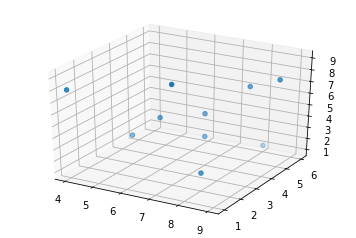

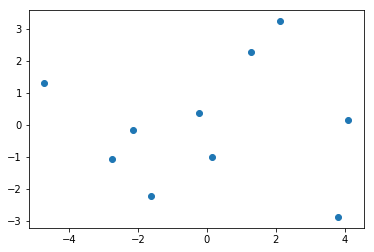

In [12]:
from mpl_toolkits.mplot3d import Axes3D
x1 = X[:,0]
y1 = X[:,1]
z1 = X[:,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( x1, y1, z1 )
plt.show()


x = X2D[:,0]
y = X2D[:,1]
plt.scatter( x,y )
plt.show()

In [13]:
#using scikitlearn for SVD decommposition to implement PCA
# (automatically handles centering the data)
from sklearn.decomposition import PCA
pca = PCA( n_components = 2 )
X2D = pca.fit_transform( X )
X2D

array([[ 2.15142276, -0.17311941],
       [-3.80418259, -2.88749898],
       [-0.15321328, -0.98688598],
       [ 4.7065185 ,  1.30153634],
       [-1.29375788,  2.27912632],
       [-4.0993133 ,  0.1435814 ],
       [ 1.62582148, -2.23208282],
       [-2.11448986,  3.2512433 ],
       [ 0.2348172 ,  0.37304031],
       [ 2.74637697, -1.06894049]])

<br>

**explained varaince ration** - the proportion of the dataset's variance that lies along each principal component.

<br>

In [16]:
# explained_variance_ratio_
X2Dvar = pca.explained_variance_ratio_
X2Dvar.sum()

0.9409505391500155

<br>

### Choosing the right number of Dimensions

1. choose the number of dimensions that add up to a sufficiently large portion of the variance (ex: 95%)
2. visualization: will need to reduce to 2 or 3 dimensions.

<br>

In [21]:
#use the mnist dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
X_train.shape

(52500, 784)

In [22]:
# approach 1
pca = PCA()
pca.fit( X_train )
cumsum = np.cumsum( pca.explained_variance_ratio_ )
d = np.argmax( cumsum >= 0.95 ) + 1
d

154

In [24]:
# or.....
pca = PCA( n_components = 0.95 )
X_reduced = pca.fit_transform( X )
X_reduced.shape

(70000, 154)

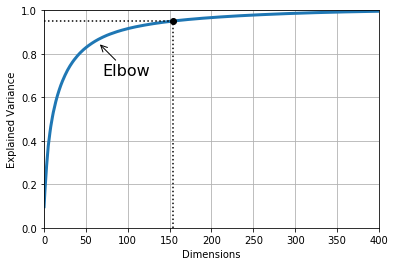

In [26]:
# plotting the variance explained as a function of PCs added
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

<br>

PCA inverse transformation: $\mathbf{X}_{recovered} = \mathbf{X}_{d-proj}\mathbf{W}_d^{\top}$  

**reconstruction error** - the mean squared distance between the original data and the reconstructed data (compressed and then recompressed)  

<br>

In [27]:
pca = PCA( n_components = 154 )
X_reduced = pca.fit_transform( X_train )
X_recovered = pca.inverse_transform( X_reduced )

Text(0.5,1,'Compressed')

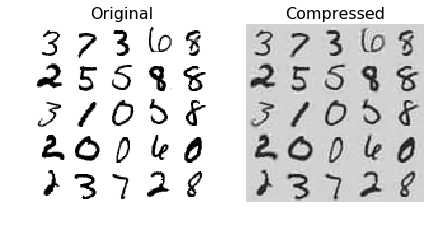

In [31]:
# plot compressed & original mnist
import matplotlib as mpl
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

<br>

### randomized PCA - if a faster algorithm is needed

    rnd_pca = PCA( n_components=154, svd_solver='randomized' )
    X_reduced = rnd_pca.fit_transform( X_train )
    
### incremental PCA - if not all of the training data can fit in memory

    from sklearn.decomposition import IncrementalPCA
    
    n_batches = 100
    inc_pca = IncrementalPCA( n_components=154 )
    for X_batch in np.array_split( X_train, n_batches ):
        inc_pca.partial_fit( X_batch )
        
    X_reduced = inc_pca.transform( X_train )
    
<br>

### Kernel PCA: selecting kernel and tuning hyperparamters

<br>

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline( [
     ('kpca', KernelPCA( n_components = 2 ) ),
     ('log_reg', LogisticRegression() )
 ] )

param_grid = [ {
    'kpca__gamma': np.linspace( 0.03, 0.05, 10 ),
    'kpca__kernel': ['rbf','sigmoid']
} ]

grid_search = GridSearchCV( clf, param_grid, cv = 3 )
grid_search.fit( X_train, y_train )
print( grid_search.best_params_ )

<br>

### LLE - Locally Linear Embedding

works by first measuring how each training instance linearly relates to it's closest neighbors and then looks for a low dimensional representation that best preserves the local relationships  

<br>

## Chapter 9: Unsupervised Learning Techniques

*if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake ... there is a huge potential in unsupervised learning that we have only barely sunk out teeth into*

<br>

### Clustering

**clustering** - the task of identifying similar instances and assigning them to groups (clusters)  
**affinity** - measure of how an instance fits into a cluster  

#### K-Means

**KMeans Algorithm:**  

1. randomly place 'K' centroids somewhere in the data range
2. label the instances
3. update the centroids...repeat 2-3 until the mean squared distance is minimizes

**hard-clustering** - assigning eeach observation to only one cluster  
**soft-clustering** - returns a similaroty score for each cluster  

<br>

In [11]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans


data = load_iris()
X = data.data
y = data.target
data.target_names
k = 5
kmeans = KMeans( n_clusters=k )
y_pred = kmeans.fit_predict( X )

In [3]:
kmeans.cluster_centers_

array([[5.508     , 2.6       , 3.908     , 1.204     ],
       [7.475     , 3.125     , 6.3       , 2.05      ],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.20769231, 2.85384615, 4.74615385, 1.56410256],
       [6.52916667, 3.05833333, 5.50833333, 2.1625    ]])

In [12]:
import numpy as np

# predict on some new dta
X_new = np.array( [ [5,2,0,2], [6,3,3,2], [6.5,3,3,3], [5.5, 3.2, 3, 2.5] ] )
kmeans.predict( X_new )

array([1, 3, 3, 3], dtype=int32)

In [13]:
# measure the distance of each instance to the centroid
kmeans.transform( X_new )

array([[6.97239557, 2.69317285, 4.994298  , 4.06499004, 5.8786774 ],
       [3.72750587, 2.57161039, 1.82016826, 1.36387096, 2.62732716],
       [3.66391867, 3.51641579, 2.27936669, 2.27906648, 2.69978666],
       [3.97797687, 2.78244137, 2.12709015, 1.69237821, 2.81020426]])

<br>

The KMeans Algorithm  

**inertia** - mean squared distance between each data point and it's closes centroid. kmeans goal: minimize inertia

**KKMeans++**

1. take one centroid chosen uniformly at random from the dataset
2. take a new centroid by choosing the distance that is more likely to be further away from already hchosen centroids
3. repeat step 2 until all *k* centroids have been selected

* using triangle inequality and keeping track up upper/lower bounds for distances between data & centroids
* `MiniBatchKMeans` to facilitate large datasets that won't fit in memory

**finding optimal *k***  

* finding the 'elbow' of inertia
* **silhouette score** - $(b-a)/\mbox{max}(a,b)$ pick a *k* with the highest score
    - a = mean distance to the other instances in the same cluster (intra-cluster distance)
    - b = mean distance to the next closest cluster

<br>

In [14]:
# silhouette score
from sklearn.metrics import silhouette_score
silhouette_score( X, kmeans.labels_ )

0.48989824728439363

<br>

KMeans is fast and scalable. However, it has problems when data clusters have varying sizes, different densities or nonspherical shapes. Scaling the data can help make ditributions approximately spherical and improve clustering, but is not a fix all.  

#### Using Clustering for Image Segmentation

implmenting **color segmentation** - assign pixels to the same segment if they have a similar color. 

<br>

In [18]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
import urllib.request

# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fd6b45ccf50>)

(533, 800, 3)


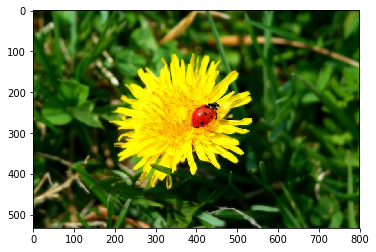

In [22]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

image = imread( os.path.join( "images", 'unsupervised_learning', 'ladybug.png' ) )
print( image.shape )
plt.imshow( image )
plt.show()

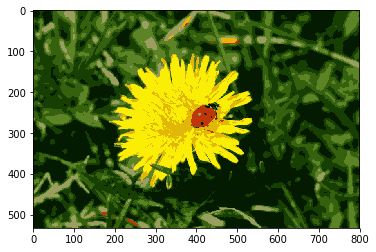

In [21]:
X = image.reshape( -1,3 )
kmeans = KMeans( n_clusters =8 ).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape( image.shape )
plt.imshow( segmented_img )
plt.show()

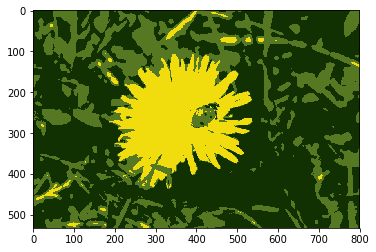

In [23]:
X = image.reshape( -1,3 )
kmeans = KMeans( n_clusters =3 ).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape( image.shape )
plt.imshow( segmented_img )
plt.show()

<br>

Even though the ladybugs color is obviously quite different from the rest of the image, KMeans with k=3 fails to cluster the red because the cluster is much smaller than the other clusters. Thhis highlights one of the shortcomings of KMeans.  

<br>

### Using Clustering for Preprocessing

clustering for dimensionality reductions for supervised learning  

<br>

In [25]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_digits, y_digits = load_digits( return_X_y=True )
X_train, X_test, y_train, y_test = train_test_split( X_digits, y_digits )
log_reg = LogisticRegression()
log_reg.fit( X_train, y_train )
log_reg.score( X_test, y_test )

/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9577777777777777

In [28]:
# add KMeans to a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    ('log_reg', LogisticRegression())
])

pipeline.fit( X_train, y_train )
pipeline.score( X_test, y_test )

/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9822222222222222

In [30]:
# use GridSearchCV to find the optimal k
from sklearn.model_selection import GridSearchCV

param_grid = dict( kmeans__n_clusters=range(2,100) )
grid_clf = GridSearchCV( pipeline, param_grid, cv=3, verbose=2 )
grid_clf.fit( X_train, y_train )

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0

[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linea

[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=5, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] ............................. kmeans__n_clusters=5, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=5, total=   0.1s
[CV] kmeans__n_clusters=6 ............................................
[CV] ............................. kmeans__n_clusters=6, total=   0.1s
[CV] kmeans__n_clusters=6 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=6, total=   0.1s
[CV] kmeans__n_clusters=6 ............................................
[CV] ............................. kmeans__n_clusters=6, total=   0.1s
[CV] kmeans__n_clusters=7 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=7, total=   0.1s
[CV] kmeans__n_clusters=7 ............................................
[CV] ............................. kmeans__n_clusters=7, total=   0.1s
[CV] kmeans__n_clusters=7 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=7, total=   0.1s
[CV] kmeans__n_clusters=8 ............................................
[CV] ............................. kmeans__n_clusters=8, total=   0.1s
[CV] kmeans__n_clusters=8 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=8, total=   0.2s
[CV] kmeans__n_clusters=8 ............................................
[CV] ............................. kmeans__n_clusters=8, total=   0.1s
[CV] kmeans__n_clusters=9 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=9, total=   0.1s
[CV] kmeans__n_clusters=9 ............................................
[CV] ............................. kmeans__n_clusters=9, total=   0.2s
[CV] kmeans__n_clusters=9 ............................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................. kmeans__n_clusters=9, total=   0.2s
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total=   0.2s
[CV] kmeans__n_clusters=10 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=10, total=   0.2s
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total=   0.2s
[CV] kmeans__n_clusters=11 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=11, total=   0.2s
[CV] kmeans__n_clusters=11 ...........................................
[CV] ............................ kmeans__n_clusters=11, total=   0.2s
[CV] kmeans__n_clusters=11 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=11, total=   0.2s
[CV] kmeans__n_clusters=12 ...........................................
[CV] ............................ kmeans__n_clusters=12, total=   0.2s
[CV] kmeans__n_clusters=12 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=12, total=   0.2s
[CV] kmeans__n_clusters=12 ...........................................
[CV] ............................ kmeans__n_clusters=12, total=   0.2s
[CV] kmeans__n_clusters=13 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=13, total=   0.2s
[CV] kmeans__n_clusters=13 ...........................................
[CV] ............................ kmeans__n_clusters=13, total=   0.2s
[CV] kmeans__n_clusters=13 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=13, total=   0.3s
[CV] kmeans__n_clusters=14 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=14, total=   0.2s
[CV] kmeans__n_clusters=14 ...........................................
[CV] ............................ kmeans__n_clusters=14, total=   0.2s
[CV] kmeans__n_clusters=14 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=14, total=   0.2s
[CV] kmeans__n_clusters=15 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=15, total=   0.3s
[CV] kmeans__n_clusters=15 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=15, total=   0.2s
[CV] kmeans__n_clusters=15 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=15, total=   0.2s
[CV] kmeans__n_clusters=16 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=16, total=   0.2s
[CV] kmeans__n_clusters=16 ...........................................
[CV] ............................ kmeans__n_clusters=16, total=   0.2s
[CV] kmeans__n_clusters=16 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=16, total=   0.2s
[CV] kmeans__n_clusters=17 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=17, total=   0.2s
[CV] kmeans__n_clusters=17 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=17, total=   0.2s
[CV] kmeans__n_clusters=17 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=17, total=   0.3s
[CV] kmeans__n_clusters=18 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=18, total=   0.3s
[CV] kmeans__n_clusters=18 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=18, total=   0.2s
[CV] kmeans__n_clusters=18 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=18, total=   0.2s
[CV] kmeans__n_clusters=19 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=19, total=   0.2s
[CV] kmeans__n_clusters=19 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=19, total=   0.2s
[CV] kmeans__n_clusters=19 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=19, total=   0.3s
[CV] kmeans__n_clusters=20 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=20, total=   0.3s
[CV] kmeans__n_clusters=20 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=20, total=   0.3s
[CV] kmeans__n_clusters=20 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=20, total=   0.3s
[CV] kmeans__n_clusters=21 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=21, total=   0.4s
[CV] kmeans__n_clusters=21 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=21, total=   0.3s
[CV] kmeans__n_clusters=21 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=21, total=   0.3s
[CV] kmeans__n_clusters=22 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=22, total=   0.3s
[CV] kmeans__n_clusters=22 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=22, total=   0.3s
[CV] kmeans__n_clusters=22 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=22, total=   0.3s
[CV] kmeans__n_clusters=23 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=23, total=   0.3s
[CV] kmeans__n_clusters=23 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=23, total=   0.3s
[CV] kmeans__n_clusters=23 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=23, total=   0.3s
[CV] kmeans__n_clusters=24 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=24, total=   0.3s
[CV] kmeans__n_clusters=24 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=24, total=   0.3s
[CV] kmeans__n_clusters=24 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=24, total=   0.3s
[CV] kmeans__n_clusters=25 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=25, total=   0.3s
[CV] kmeans__n_clusters=25 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=25, total=   0.3s
[CV] kmeans__n_clusters=25 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=25, total=   0.3s
[CV] kmeans__n_clusters=26 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=26, total=   0.3s
[CV] kmeans__n_clusters=26 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=26, total=   0.3s
[CV] kmeans__n_clusters=26 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=26, total=   0.4s
[CV] kmeans__n_clusters=27 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=27, total=   0.4s
[CV] kmeans__n_clusters=27 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=27, total=   0.4s
[CV] kmeans__n_clusters=27 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=27, total=   0.3s
[CV] kmeans__n_clusters=28 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=28, total=   0.4s
[CV] kmeans__n_clusters=28 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=28, total=   0.3s
[CV] kmeans__n_clusters=28 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=28, total=   0.3s
[CV] kmeans__n_clusters=29 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=29, total=   0.4s
[CV] kmeans__n_clusters=29 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=29, total=   0.4s
[CV] kmeans__n_clusters=29 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=29, total=   0.4s
[CV] kmeans__n_clusters=30 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=30, total=   0.4s
[CV] kmeans__n_clusters=30 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=30, total=   0.4s
[CV] kmeans__n_clusters=30 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=30, total=   0.4s
[CV] kmeans__n_clusters=31 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=31, total=   0.4s
[CV] kmeans__n_clusters=31 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=31, total=   0.4s
[CV] kmeans__n_clusters=31 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=31, total=   0.4s
[CV] kmeans__n_clusters=32 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=32, total=   0.4s
[CV] kmeans__n_clusters=32 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=32, total=   0.4s
[CV] kmeans__n_clusters=32 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=32, total=   0.4s
[CV] kmeans__n_clusters=33 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=33, total=   0.4s
[CV] kmeans__n_clusters=33 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=33, total=   0.4s
[CV] kmeans__n_clusters=33 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=33, total=   0.4s
[CV] kmeans__n_clusters=34 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=34, total=   0.5s
[CV] kmeans__n_clusters=34 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=34, total=   0.5s
[CV] kmeans__n_clusters=34 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=34, total=   0.5s
[CV] kmeans__n_clusters=35 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=35, total=   0.4s
[CV] kmeans__n_clusters=35 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=35, total=   0.5s
[CV] kmeans__n_clusters=35 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=35, total=   0.5s
[CV] kmeans__n_clusters=36 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=36, total=   0.6s
[CV] kmeans__n_clusters=36 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=36, total=   0.5s
[CV] kmeans__n_clusters=36 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=36, total=   0.5s
[CV] kmeans__n_clusters=37 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=37, total=   0.5s
[CV] kmeans__n_clusters=37 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=37, total=   0.6s
[CV] kmeans__n_clusters=37 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=37, total=   0.6s
[CV] kmeans__n_clusters=38 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=38, total=   0.5s
[CV] kmeans__n_clusters=38 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=38, total=   0.6s
[CV] kmeans__n_clusters=38 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=38, total=   0.6s
[CV] kmeans__n_clusters=39 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=39, total=   0.6s
[CV] kmeans__n_clusters=39 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=39, total=   0.5s
[CV] kmeans__n_clusters=39 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=39, total=   0.6s
[CV] kmeans__n_clusters=40 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=40, total=   0.5s
[CV] kmeans__n_clusters=40 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=40, total=   0.6s
[CV] kmeans__n_clusters=40 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=40, total=   0.6s
[CV] kmeans__n_clusters=41 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=41, total=   0.5s
[CV] kmeans__n_clusters=41 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=41, total=   0.5s
[CV] kmeans__n_clusters=41 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=41, total=   0.6s
[CV] kmeans__n_clusters=42 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=42, total=   0.6s
[CV] kmeans__n_clusters=42 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=42, total=   0.6s
[CV] kmeans__n_clusters=42 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=42, total=   0.5s
[CV] kmeans__n_clusters=43 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=43, total=   0.6s
[CV] kmeans__n_clusters=43 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=43, total=   0.7s
[CV] kmeans__n_clusters=43 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=43, total=   0.6s
[CV] kmeans__n_clusters=44 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=44, total=   0.6s
[CV] kmeans__n_clusters=44 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=44, total=   0.6s
[CV] kmeans__n_clusters=44 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=44, total=   0.7s
[CV] kmeans__n_clusters=45 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=45, total=   0.6s
[CV] kmeans__n_clusters=45 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=45, total=   0.6s
[CV] kmeans__n_clusters=45 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=45, total=   0.6s
[CV] kmeans__n_clusters=46 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=46, total=   0.5s
[CV] kmeans__n_clusters=46 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=46, total=   0.8s
[CV] kmeans__n_clusters=46 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=46, total=   0.6s
[CV] kmeans__n_clusters=47 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=47, total=   0.8s
[CV] kmeans__n_clusters=47 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=47, total=   0.7s
[CV] kmeans__n_clusters=47 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=47, total=   0.8s
[CV] kmeans__n_clusters=48 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=48, total=   0.6s
[CV] kmeans__n_clusters=48 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=48, total=   0.6s
[CV] kmeans__n_clusters=48 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=48, total=   0.7s
[CV] kmeans__n_clusters=49 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=49, total=   0.6s
[CV] kmeans__n_clusters=49 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=49, total=   0.7s
[CV] kmeans__n_clusters=49 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=49, total=   0.6s
[CV] kmeans__n_clusters=50 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=50, total=   0.6s
[CV] kmeans__n_clusters=50 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=50, total=   0.6s
[CV] kmeans__n_clusters=50 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=50, total=   0.6s
[CV] kmeans__n_clusters=51 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=51, total=   0.6s
[CV] kmeans__n_clusters=51 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=51, total=   0.7s
[CV] kmeans__n_clusters=51 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=51, total=   0.8s
[CV] kmeans__n_clusters=52 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=52, total=   0.6s
[CV] kmeans__n_clusters=52 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=52, total=   0.6s
[CV] kmeans__n_clusters=52 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=52, total=   0.7s
[CV] kmeans__n_clusters=53 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=53, total=   0.8s
[CV] kmeans__n_clusters=53 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=53, total=   0.6s
[CV] kmeans__n_clusters=53 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=53, total=   0.7s
[CV] kmeans__n_clusters=54 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=54, total=   0.7s
[CV] kmeans__n_clusters=54 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=54, total=   0.7s
[CV] kmeans__n_clusters=54 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=54, total=   0.7s
[CV] kmeans__n_clusters=55 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=55, total=   0.7s
[CV] kmeans__n_clusters=55 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=55, total=   0.6s
[CV] kmeans__n_clusters=55 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=55, total=   0.7s
[CV] kmeans__n_clusters=56 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=56, total=   0.7s
[CV] kmeans__n_clusters=56 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=56, total=   0.7s
[CV] kmeans__n_clusters=56 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=56, total=   0.7s
[CV] kmeans__n_clusters=57 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=57, total=   0.8s
[CV] kmeans__n_clusters=57 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=57, total=   0.7s
[CV] kmeans__n_clusters=57 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=57, total=   0.7s
[CV] kmeans__n_clusters=58 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=58, total=   0.7s
[CV] kmeans__n_clusters=58 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=58, total=   0.7s
[CV] kmeans__n_clusters=58 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=58, total=   0.6s
[CV] kmeans__n_clusters=59 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=59, total=   0.7s
[CV] kmeans__n_clusters=59 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=59, total=   0.7s
[CV] kmeans__n_clusters=59 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=59, total=   0.7s
[CV] kmeans__n_clusters=60 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=60, total=   0.7s
[CV] kmeans__n_clusters=60 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=60, total=   0.7s
[CV] kmeans__n_clusters=60 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=60, total=   0.7s
[CV] kmeans__n_clusters=61 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=61, total=   0.7s
[CV] kmeans__n_clusters=61 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=61, total=   0.7s
[CV] kmeans__n_clusters=61 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=61, total=   0.7s
[CV] kmeans__n_clusters=62 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=62, total=   0.8s
[CV] kmeans__n_clusters=62 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=62, total=   0.7s
[CV] kmeans__n_clusters=62 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=62, total=   0.7s
[CV] kmeans__n_clusters=63 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=63, total=   0.7s
[CV] kmeans__n_clusters=63 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=63, total=   0.7s
[CV] kmeans__n_clusters=63 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=63, total=   0.8s
[CV] kmeans__n_clusters=64 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=64, total=   0.8s
[CV] kmeans__n_clusters=64 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=64, total=   0.8s
[CV] kmeans__n_clusters=64 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=64, total=   0.8s
[CV] kmeans__n_clusters=65 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=65, total=   0.8s
[CV] kmeans__n_clusters=65 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=65, total=   0.8s
[CV] kmeans__n_clusters=65 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=65, total=   0.7s
[CV] kmeans__n_clusters=66 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=66, total=   0.7s
[CV] kmeans__n_clusters=66 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=66, total=   0.8s
[CV] kmeans__n_clusters=66 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=66, total=   0.8s
[CV] kmeans__n_clusters=67 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=67, total=   0.7s
[CV] kmeans__n_clusters=67 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=67, total=   0.8s
[CV] kmeans__n_clusters=67 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=67, total=   0.8s
[CV] kmeans__n_clusters=68 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=68, total=   0.8s
[CV] kmeans__n_clusters=68 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=68, total=   0.8s
[CV] kmeans__n_clusters=68 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=68, total=   0.8s
[CV] kmeans__n_clusters=69 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=69, total=   0.8s
[CV] kmeans__n_clusters=69 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=69, total=   0.8s
[CV] kmeans__n_clusters=69 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=69, total=   0.8s
[CV] kmeans__n_clusters=70 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=70, total=   0.8s
[CV] kmeans__n_clusters=70 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=70, total=   0.8s
[CV] kmeans__n_clusters=70 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=70, total=   0.8s
[CV] kmeans__n_clusters=71 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=71, total=   0.8s
[CV] kmeans__n_clusters=71 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=71, total=   0.8s
[CV] kmeans__n_clusters=71 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=71, total=   0.8s
[CV] kmeans__n_clusters=72 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=72, total=   0.8s
[CV] kmeans__n_clusters=72 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=72, total=   0.8s
[CV] kmeans__n_clusters=72 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=72, total=   0.8s
[CV] kmeans__n_clusters=73 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=73, total=   0.8s
[CV] kmeans__n_clusters=73 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=73, total=   0.8s
[CV] kmeans__n_clusters=73 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=73, total=   0.8s
[CV] kmeans__n_clusters=74 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=74, total=   0.8s
[CV] kmeans__n_clusters=74 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=74, total=   0.9s
[CV] kmeans__n_clusters=74 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=74, total=   0.8s
[CV] kmeans__n_clusters=75 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=75, total=   0.8s
[CV] kmeans__n_clusters=75 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=75, total=   0.8s
[CV] kmeans__n_clusters=75 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=75, total=   0.8s
[CV] kmeans__n_clusters=76 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=76, total=   0.9s
[CV] kmeans__n_clusters=76 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=76, total=   0.9s
[CV] kmeans__n_clusters=76 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=76, total=   0.8s
[CV] kmeans__n_clusters=77 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=77, total=   0.8s
[CV] kmeans__n_clusters=77 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=77, total=   0.9s
[CV] kmeans__n_clusters=77 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=77, total=   0.8s
[CV] kmeans__n_clusters=78 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=78, total=   0.9s
[CV] kmeans__n_clusters=78 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=78, total=   0.9s
[CV] kmeans__n_clusters=78 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=78, total=   0.8s
[CV] kmeans__n_clusters=79 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=79, total=   0.9s
[CV] kmeans__n_clusters=79 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=79, total=   0.9s
[CV] kmeans__n_clusters=79 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=79, total=   0.9s
[CV] kmeans__n_clusters=80 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=80, total=   0.8s
[CV] kmeans__n_clusters=80 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=80, total=   0.9s
[CV] kmeans__n_clusters=80 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=80, total=   0.9s
[CV] kmeans__n_clusters=81 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=81, total=   0.8s
[CV] kmeans__n_clusters=81 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=81, total=   0.9s
[CV] kmeans__n_clusters=81 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=81, total=   0.9s
[CV] kmeans__n_clusters=82 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=82, total=   0.9s
[CV] kmeans__n_clusters=82 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=82, total=   0.9s
[CV] kmeans__n_clusters=82 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=82, total=   0.9s
[CV] kmeans__n_clusters=83 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=83, total=   0.9s
[CV] kmeans__n_clusters=83 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=83, total=   0.9s
[CV] kmeans__n_clusters=83 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=83, total=   0.9s
[CV] kmeans__n_clusters=84 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=84, total=   0.9s
[CV] kmeans__n_clusters=84 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=84, total=   0.9s
[CV] kmeans__n_clusters=84 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=84, total=   0.9s
[CV] kmeans__n_clusters=85 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=85, total=   0.9s
[CV] kmeans__n_clusters=85 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=85, total=   0.9s
[CV] kmeans__n_clusters=85 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=85, total=   0.9s
[CV] kmeans__n_clusters=86 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=86, total=   0.9s
[CV] kmeans__n_clusters=86 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=86, total=   0.9s
[CV] kmeans__n_clusters=86 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=86, total=   0.9s
[CV] kmeans__n_clusters=87 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=87, total=   0.9s
[CV] kmeans__n_clusters=87 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=87, total=   0.9s
[CV] kmeans__n_clusters=87 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=87, total=   1.0s
[CV] kmeans__n_clusters=88 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=88, total=   0.9s
[CV] kmeans__n_clusters=88 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=88, total=   0.9s
[CV] kmeans__n_clusters=88 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=88, total=   1.0s
[CV] kmeans__n_clusters=89 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=89, total=   1.0s
[CV] kmeans__n_clusters=89 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=89, total=   0.9s
[CV] kmeans__n_clusters=89 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=89, total=   1.0s
[CV] kmeans__n_clusters=90 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=90, total=   0.9s
[CV] kmeans__n_clusters=90 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=90, total=   0.9s
[CV] kmeans__n_clusters=90 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=90, total=   0.9s
[CV] kmeans__n_clusters=91 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=91, total=   1.0s
[CV] kmeans__n_clusters=91 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=91, total=   1.0s
[CV] kmeans__n_clusters=91 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=91, total=   1.0s
[CV] kmeans__n_clusters=92 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=92, total=   1.0s
[CV] kmeans__n_clusters=92 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=92, total=   0.9s
[CV] kmeans__n_clusters=92 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=92, total=   1.0s
[CV] kmeans__n_clusters=93 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=93, total=   0.9s
[CV] kmeans__n_clusters=93 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=93, total=   1.0s
[CV] kmeans__n_clusters=93 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=93, total=   1.0s
[CV] kmeans__n_clusters=94 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=94, total=   1.0s
[CV] kmeans__n_clusters=94 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=94, total=   1.0s
[CV] kmeans__n_clusters=94 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=94, total=   1.0s
[CV] kmeans__n_clusters=95 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=95, total=   1.0s
[CV] kmeans__n_clusters=95 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=95, total=   1.0s
[CV] kmeans__n_clusters=95 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=95, total=   1.0s
[CV] kmeans__n_clusters=96 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=96, total=   1.0s
[CV] kmeans__n_clusters=96 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=96, total=   1.0s
[CV] kmeans__n_clusters=96 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=96, total=   1.0s
[CV] kmeans__n_clusters=97 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=97, total=   1.0s
[CV] kmeans__n_clusters=97 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=97, total=   1.0s
[CV] kmeans__n_clusters=97 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=97, total=   1.0s
[CV] kmeans__n_clusters=98 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=98, total=   1.0s
[CV] kmeans__n_clusters=98 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=98, total=   1.0s
[CV] kmeans__n_clusters=98 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=98, total=   1.0s
[CV] kmeans__n_clusters=99 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=99, total=   1.0s
[CV] kmeans__n_clusters=99 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=99, total=   1.0s
[CV] kmeans__n_clusters=99 ...........................................


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ............................ kmeans__n_clusters=99, total=   1.0s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  3.0min finished
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'kmeans__n_clusters': 89}


AttributeError: 'GridSearchCV' object has no attribute 'scores'

In [31]:
print( grid_clf.best_params_ )
print( grid_clf.score( X_test, y_test ))

{'kmeans__n_clusters': 89}
0.9755555555555555


<br>

### DBSCAN

**DBSCAN** - define clusters as continuous regions of high density  

* **$\epsilon$-neighborhood** - count the number of instances associated with an area
* **min_samples** - if an instance has min_samples within the $\epsilon$-neighborhood, it is considered a dense region
* **core instance** - instances located within a dense region
* all instances within the neighborhood of a core instance belong to the same cluster
* long sequences of neighboring core instances form the same cluster. This is not restricted to a spherical shape like KMeans was

<br>

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons( n_samples=1000, noise=0.05 )
dbscan = DBSCAN( eps=0.05, min_samples=5 )
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [34]:
dbscan.labels_[0:10]

array([-1,  0,  1,  2,  3,  1,  4,  0,  2,  1])

In [37]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

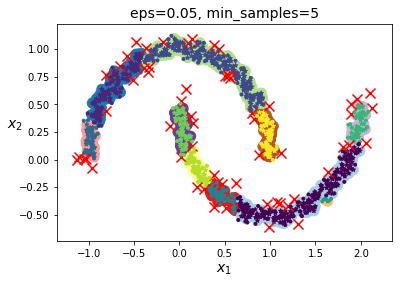

In [38]:
plot_dbscan(dbscan, X, size=100)

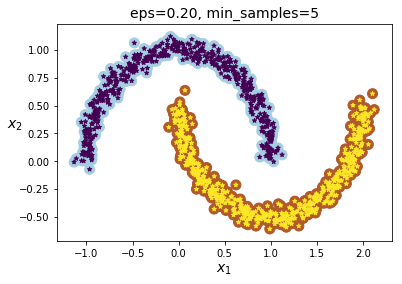

In [39]:
dbscan2 = DBSCAN( eps=0.2, min_samples=5 )
dbscan2.fit(X)

plot_dbscan(dbscan2, X, size=100)

<br>

### Gaussian Mixtures

**Gaussian Mixture Model** - a probabiistic model that assumes that the instances were generated from several Gaussian distributions whose parameters are unknown. All the instances formed froma single Gaussian distribution for a cluster that typically looks like an ellipsoid.  
**Expectation Maximization Algorithm**  

1. initialize parameters randomly
2. assign instances to clusters (Expectation)
3. update the clusters (Maximization)
4. repeat Expectation & Maximization until convergence

Gaussian Mixture Model is a generative model: you can generate new insteances from it.  

Select the nuber of clusters by finding a model that minimizes a theoretical information criterion such as the *Bayesian Information Criterion* or the *Akaike Information Criterion*

### Anomoly Detection

**anomoly detection** - the task of detecting instances that deviate strongly from the norm  
set a density threshold for the clusters such that points outside the threshold are labelled outliers

### Bayesian Gaussian Mixture Model

the Bayesian Gaussian Mixture Model is capable of giving weights ~zero to unnecessary clusters

<br>

## Chapter 10: Introduction to artificial Neural Networks with Keras

looking to the brains architecture for inspiration on how to build an intelligent machine.  
**Artificial Neural Network** (ANN) - is a machine learning model inspired by the networks of biological neurons found in our brains.  

***

**From Biological to Artificial Neurons**  
ANNs were first described very early on by [McCulloch & Pitts, 1943](https://www.cs.cmu.edu/~./epxing/Class/10715/reading/McCulloch.and.Pitts.pdf)  

![](mc1943.jpeg)

ANNs frequently outperform other ML models when there are huge ammounts of data involved on very large and complex problems.  

Simple units: the **artificial neuron** - has one or more binaray inputs and one binary output. the artificial neuron activates its output when more than a certain number of inputs are active. With just these simplified units, it is possible to build a network with complex properties.

[**Perceptron**](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.335.3398&rep=rep1&type=pdf) (Rosenblatt 1957)  
**Threshold Logic Unit** (TLU) or the Linear Threshold Unit (LTU) - the inputs and outputs are  numbers and each input connection is associated with a weight. the TLU computes the weighted sum of its inputs and then applies a step function to the sum and outputs the result. there are different step functions that can be used (heaviside, sign, etc)  
**Perceptron** - composed of a layer of TLUs  
**fully connected layer** - every TLU in a perceptron is connected to every TLU in the previous layer  
**input neurons** - inputs to the ANN are passed through input neurons  
**bias neurons** - bias features are added to the system (e.g. $x_1=0$)  
**input layer** - input neurons and bias neurons  

Computing the outputs of a fully connected layer:  $$h_{\mathbf{W},\mathbf{b}}(\mathbf{X}) = \phi(\mathbf{XW} + \mathbf{b})$$  
where:  

* $\mathbf{X}$ = matrix of input features
* $\mathbf{W}$ = contains all the weights
* $\mathbf{b}$ = the bias connection weights
* $\phi$ = the step function

**Perceptron training** - originally based on Hebb's rule, "Cell's that wire together, fire together". Perceptrons are trained with a variant of this rule that takes into account error made by the network when it makes a prediction: $$w_{i,j}^{(\mbox{next step})} = w_{i,j}+ \eta(y_j-\hat{y}_j)x_i$$

where:  

* $w_{i,j}$ = wieghts from input to output neuron
* $x_i$ = input value for the *i*th training instance
* $y_j$ & $\hat{y}_j$ = the output and target output of the *j*th output neuron for the current training instance
* $\eta$ = the learning rate

**Perceptron convergence theorem** - if the training instances are linearly seperable, the algorithm will converge on a solution

<br>

In [3]:
# demonstrate scikit-learn's Perceptron class
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[ :, (2,3) ] #pedal length
y = (iris.target ==0).astype( np.int )

per_clf = Perceptron()
per_clf.fit( X,y )

y_pred = per_clf.predict( [ [ 2,0.5 ] ] )
print( y_pred )

[1]


/home/bonzilla/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<br>

### Multilayered Perceptrons and Backpropagation

a major critique of Rosenblatt's Perceptrons is that they are incapable of some trivial logic such as the exclusive or (XOR). However, as it turns out, stacking Perceptrons on top of each other can solve this issue.  
**Multilayer Perceptron** - composed of an input layer, one or more TLU layers (hidden layers) and a final output layer. every layer except the output layer contains a bias neuron and is fully connected to the output layer. 
**deep learning** - refers to the depth of the hidden layers of the NN  
**backpropagation** - proposed in the late 80s by [Rumelhart, Hinton & Williams](http://www.cs.toronto.edu/~hinton/absps/families.pdf) as a way to train MLPs. In short: backpropagation is a gradient descent to compute the network's error with regard to the models parameters. it finds how each connection and bias weight can be tweaked to reduce the error. see **autodiff**  

**Summary of the backpropagation algorithm:** for each training instance, the backpropagation aalgorithm first makes a prediction (forward pass) andmeasures the error, then goes through each layer in reverse to measure the error contributed from each connection (reverse pass), and finally tweaks the connection weights to reduce the error (Gradient Descent step). uses different activation functions: backs off from step fxn in favor a fxns with well-defined nozero derivatives everywhere: logistic, hyperbolic tangent, rectified linear unit.  

**Why activation functions?:** you need to add some nonlinearity between the layers. without nonlinearity, even deep NNs are equivalent to a single layer. On the other hand, a large enough deep NN with nonlinear activation can theoretically approximate any continuous function.  

**How to compute NN outputs:**  

* **Regression MLPs** 

|     **Hyperparameter**    |                          **Typical Value**                          |
|:-------------------------:|:-------------------------------------------------------------------:|
| #input neurons            | One per input feature (e.g. 28x28=784 for MNIST)                    |
| #hidden layers            | Depends, but typically 1 to 5                                       |
| #neurons per hidden layer | Depends, but typically 10 to 100                                    |
| #output neurons           | 1 per prediction dimention                                          |
| Hidden Activation         | ReLU (or SELU)                                                      |
| Output Activation         | None, ReLU (or SELU)/softplus, or logistic/tanh (if bounded inputs) |
| Loss Function             | MSE or MAE/Huber(if outliers)                                       |

* **Classification MLPs** - 

|    **Hyperparameter**   | **Binary Classification** | **Mulitlabel binary classification** | **Multiclass Classification** |
|:-----------------------:|:-------------------------:|--------------------------------------|-------------------------------|
| input and hidden layers | Same as regression        | Same as regression                   | Same as regression            |
| #output layers          | 1                         | 1 per label                          | 1 per class                   |
| Output layer activation | Logistic                  | Logistic                             | Softmax                       |
| Loss function           | Cross entropy             | Cross entropy                        | Cross entropy                 |

<br>

Now to visit [Tensorflow Playground](https://playground.tensorflow.org/)....

In [5]:
import tensorflow as tf
from tensorflow import keras
print( tf.__version__ )
print( keras.__version__ )

2.5.0
2.5.0


<br>

### Building an Image Classifier Using the Sequential API

<br>

In [8]:
# Building an image classifier

# load the dataset Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
( X_train_full, y_train_full ), ( X_test, y_test ) = fashion_mnist.load_data()
print( X_train_full.shape )
print( X_train_full.dtype )

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
uint8


In [15]:
print( y_train_full.shape )
print( y_train_full.dtype )
print( y_train_full[0:10] )

(60000,)
uint8
[9 0 0 3 0 2 7 2 5 5]


In [16]:
# create a validation set and also scale the values for use with gradient descent
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' ]

print( class_names[ y_train[0] ] )

Coat


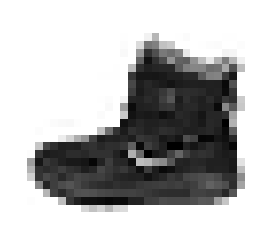

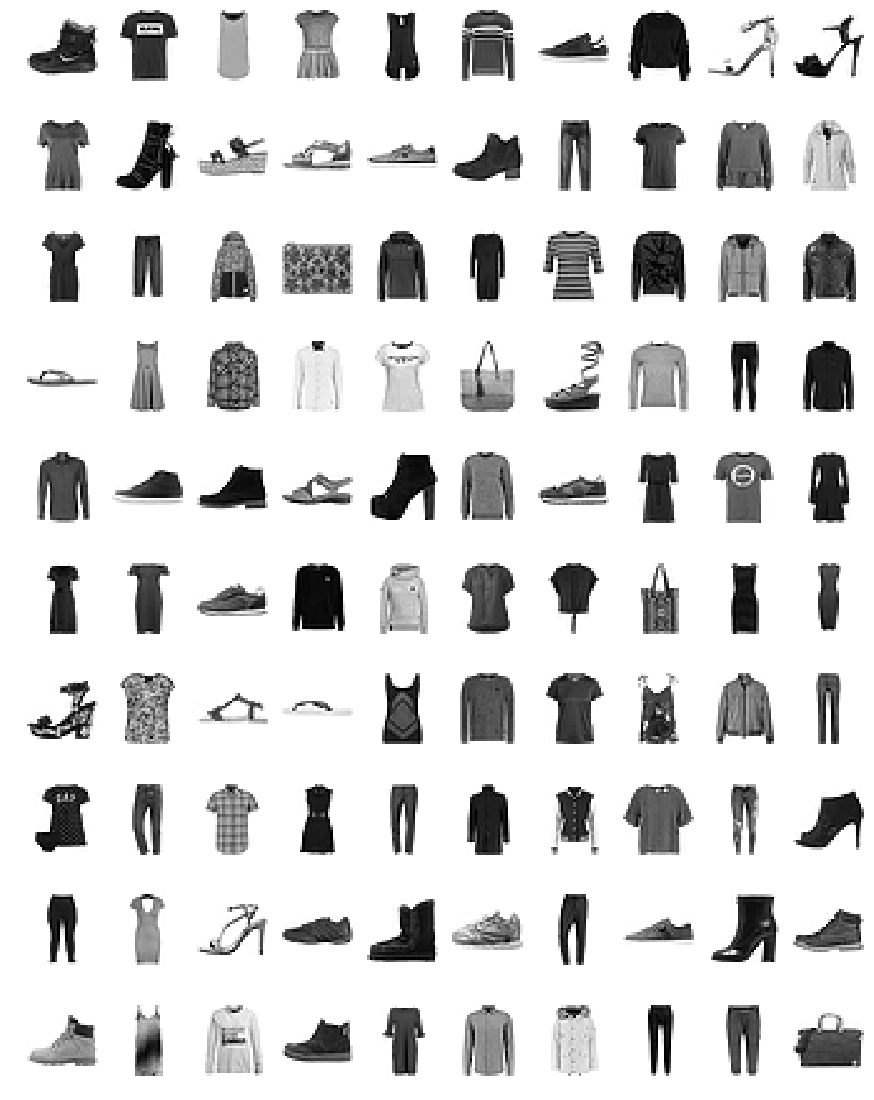

In [20]:
#take a look at one of the images
import matplotlib as mpl
import matplotlib.pyplot as plt

some_pic = X_valid[0]
some_pic_image = some_pic.reshape( 28, 28 )

plt.imshow( some_pic_image, cmap = "binary" )
plt.axis( 'off' )
plt.show()

fig = plt.subplots(figsize=(15, 20))
    #plt.subplots_adjust( hspace = 0.1 )
    
a = 10  # number of rows
b = 10  # number of columns

for pic in range(0,100):
    some_digit = X_valid[pic]
    plt.subplot( a,b,pic + 1 )
    some_pic_image = some_digit.reshape( 28, 28 )
    plt.imshow( some_pic_image, cmap = "binary" )
    plt.axis( 'off' )


In [21]:
# create a model using the Sequential API

# instantiate a Sequential model.
# this is a simple model of just sequential layers
model = keras.models.Sequential() 
# build the first layer.
# the flatten layer which just takes the image and coverts it to 1D
model.add( keras.layers.Flatten( input_shape = [ 28,28 ] ) )
# add a dense hidden layer using the ReLU activation function
model.add( keras.layers.Dense( 300, activation = 'relu' ) )
# add another dense hidden layer using the ReLU activation function
model.add( keras.layers.Dense( 100, activation = 'relu' ) )
# add a dense output layer using softmax with one output for each class
model.add( keras.layers.Dense( 10, activation = 'softmax' ) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers

In [23]:
# Compile the model. here we specify the loss function and the optimizer to use
model.compile( loss = 'sparse_categorical_crossentropy', # our labels are sparse
             optimizer = 'sgd', # stochastic gradient descent
             metrics = ['accuracy'] )

In [24]:
# training the model
history = model.fit( X_train, y_train, epochs = 30, 
                   validation_data = ( X_valid, y_valid ) )

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7079 - accuracy: 0.7680 - val_loss: 0.5236 - val_accuracy: 0.8154
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4812 - accuracy: 0.8325 - val_loss: 0.4517 - val_accuracy: 0.8412
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4375 - accuracy: 0.8463 - val_loss: 0.4032 - val_accuracy: 0.8622
Epoch 4/30
1719/1719 [==============================] - 2s 994us/step - loss: 0.4098 - accuracy: 0.8562 - val_loss: 0.3911 - val_accuracy: 0.8628
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3908 - accuracy: 0.8625 - val_loss: 0.3733 - val_accuracy: 0.8710
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3748 - accuracy: 0.8673 - val_loss: 0.3768 - val_accuracy: 0.8710
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3618 - accuracy: 0.8721 - val_loss: 0.3685 - val_accurac

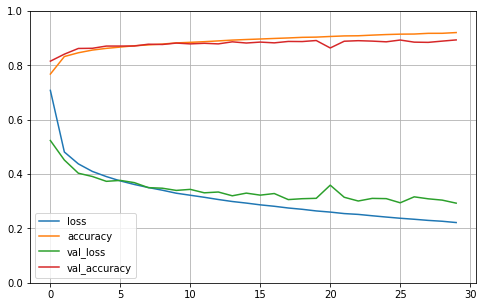

In [26]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame( history.history ).plot( figsize = (8,5) )
plt.grid( True )
plt.gca().set_ylim( 0,1 )
plt.show()

<br>

both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Moreovver, the validation curves are close to the training curves, which means that there is not too much overfitting

<br>

In [27]:
# use the model to classify previously unseen data
model.evaluate( X_test, y_test )

313/313 [==============================] - 0s 1ms/step - loss: 59.1827 - accuracy: 0.8607


[59.18268585205078, 0.8607000112533569]

In [34]:
# return some predictions for a few instances from the test data
# the results will give the prabability per class
X_new = X_test[:10]
y_proba = model.predict( X_new )
y_proba

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']


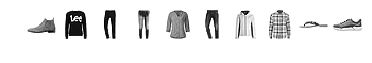

In [36]:
import numpy as np

y_pred = model.predict_classes( X_new )
print( np.array( class_names )[ y_pred ] )

a = 1  # number of rows
b = 10  # number of columns

for pic in range(0,10):
    some_digit = X_test[pic]
    plt.subplot( a,b,pic + 1 )
    some_pic_image = some_digit.reshape( 28, 28 )
    plt.imshow( some_pic_image, cmap = "binary" )
    plt.axis( 'off' )

<br>

### Building a Regression MLP Using the Sequential API

<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split( housing.data, housing.target )
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full )

scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_valid = scaler.transform( X_valid )
X_test = scaler.transform( X_test )

In [2]:
model = keras.models.Sequential([
    keras.layers.Dense( 30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(1) #only predicting a single value
])

model.compile( loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit( X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate( X_test, y_test )
X_new = X_test[:3]
y_pred = model.predict( X_new )
print( y_pred )

/home/bonzilla/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
363/363 [==============================] - 1s 870us/step - loss: 1.9335 - val_loss: 0.8488
Epoch 2/20
363/363 [==============================] - 0s 639us/step - loss: 0.8004 - val_loss: 0.7308
Epoch 3/20
363/363 [==============================] - 0s 683us/step - loss: 0.7275 - val_loss: 0.6860
Epoch 4/20
363/363 [==============================] - 0s 751us/step - loss: 0.6844 - val_loss: 0.6504
Epoch 5/20
363/363 [==============================] - 0s 714us/step - loss: 0.6488 - val_loss: 0.6209
Epoch 6/20
363/363 [==============================] - 0s 654us/step - loss: 0.6191 - val_loss: 0.5972
Epoch 7/20
363/363 [==============================] - 0s 680us/step - loss: 0.5943 - val_loss: 0.5772
Epoch 8/20
363/363 [==============================] - 0s 628us/step - loss: 0.5735 - val_loss: 0.5610
Epoch 9/20
363/363 [==============================] - 0s 630us/step - loss: 0.5558 - val_loss: 0.5476
Epoch 10/20
363/363 [==============================] - 0s 665us/step - loss: 0.541

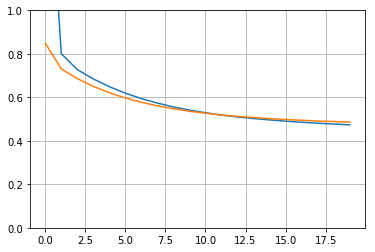

In [3]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

<br>

### Building Complex Topologies with the Functional API

Non-sequential neural nets.  
ex: [widedeep](https://arxiv.org/pdf/1606.07792.pdf) - connects all or part of the inputs directly to the output layer making it possible for the model to learn both deep patterns and simple rules.

<br>

In [7]:
# build a widedeep model for the california housing problem:

# specify the input
input_A = keras.layers.Input( shape = [5], name = 'wide_input')
input_B = keras.layers.Input( shape = [6], name = 'deep_input')
# connect to a dense layers
hidden1 = keras.layers.Dense( 30, activation = 'relu')(input_B)
# connect to another dense layer
hidden2 = keras.layers.Dense( 30, activation = 'relu')(hidden1)
# connect to a concatenate layer
concat = keras.layers.Concatenate()([input_A,hidden2])
# connect to a output layer with 1 neuron
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)
model = keras.Model(inputs=[input_A,input_B],outputs=[output, aux_output])


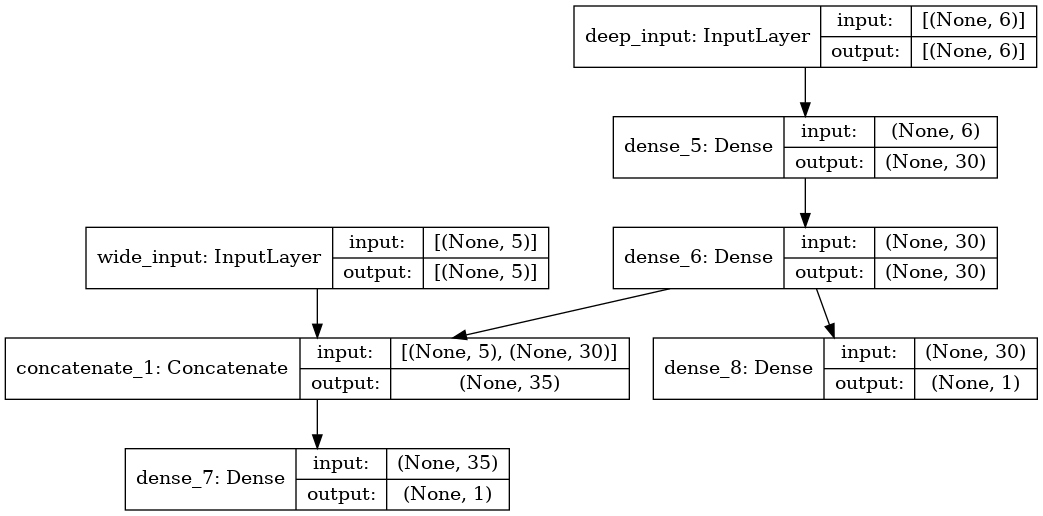

In [8]:
keras.utils.plot_model(model, "widedeep.png", show_shapes=True)

In [12]:
model.compile( loss = ['mse','mse'], loss_weights = [0.9,0.1], optimizer = keras.optimizers.SGD( lr = 1e-3))
X_train_A, X_train_B = X_train[:,:5], X_train[:,2:]
X_valid_A, X_valid_B = X_valid[:,:5], X_valid[:,2:]
X_test_A, X_test_B = X_test[:,:5], X_test[:,2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                   validation_data = ((X_valid_A, X_valid_B), [y_valid, y_valid]))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4798 - dense_7_loss: 0.4525 - dense_8_loss: 0.7255 - val_loss: 0.5041 - val_dense_7_loss: 0.4769 - val_dense_8_loss: 0.7496
Epoch 2/20
363/363 [==============================] - 0s 954us/step - loss: 0.4786 - dense_7_loss: 0.4516 - dense_8_loss: 0.7209 - val_loss: 0.5025 - val_dense_7_loss: 0.4755 - val_dense_8_loss: 0.7454
Epoch 3/20
363/363 [==============================] - 0s 947us/step - loss: 0.4763 - dense_7_loss: 0.4495 - dense_8_loss: 0.7167 - val_loss: 0.5011 - val_dense_7_loss: 0.4743 - val_dense_8_loss: 0.7422
Epoch 4/20
363/363 [==============================] - 0s 917us/step - loss: 0.4750 - dense_7_loss: 0.4485 - dense_8_loss: 0.7130 - val_loss: 0.5010 - val_dense_7_loss: 0.4745 - val_dense_8_loss: 0.7395
Epoch 5/20
363/363 [==============================] - 0s 851us/step - loss: 0.4734 - dense_7_loss: 0.4471 - dense_8_loss: 0.7101 - val_loss: 0.4983 - val_dense_7_loss: 0.4719 - val_dense_8_loss:

In [13]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 611us/step - loss: 0.4872 - dense_7_loss: 0.4651 - dense_8_loss: 0.6861


<br>

Saving a Model:  

    model = keras.models.Sequential([...])
    model.compile([...])
    model.fit([...])
    model.save('my_keras_model.h5')
    
<br>

<br>

Subclassing the model class allows you to makes it easier to implement flexible operations such as for loops, if statements etc by using the `call()` method

<br>

In [15]:
# subclass the widedeep model

class WideAndDeepModel( keras.Model ):
    def __init__( self, units= 30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense( units, activation=activation)
        self.hidden2 = keras.layers.Dense( units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call( self, inputs ):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate( concat )
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel()

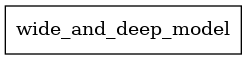

In [16]:
keras.utils.plot_model(model, "widedeep.png", show_shapes=True)

<br>

#### Using Callbacks to Save Training Checkpoints

    [...] # build and compile model
    checkpoint_cb = keras.callbacks.ModelCheckpoint( 'my_keras_model.h5' )
    early_stopping_cb = keras.callbacks.EarlyStopping( patience = 10, restore_best_weights = True )
    history = model.fit( X_train, y_train, epochs=10, callbacks=[checkpoint_cb, earlystopping_cb]

<br>

### Fine-Tuning NN Hyperparameters

How do you know what combination of hyperparameters is best for your task?  

* Radomized sampling of parameter space to find optimal values
* Zooming - when a region of the parameter space turns out to be good, it should be explored more.
* Evolutionary algorithms for hyperparameter tuning

<br>

In [18]:
# an implementation of randomized search to tune hyperparameters...
# .............this will take a while

def build_model( n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add( keras.layers.InputLayer( input_shape = input_shape ))
    for layer in range( n_hidden ):
        model.add( keras.layers.Dense( n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile( loss = 'mse',optimizer = optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor( build_model )

keras_reg.fit( X_train, y_train, epochs=100,
             validation_data = ( X_valid, y_valid ),
             callbacks = [keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score( X_test, y_test )
y_pred = keras_reg.predict( X_new )

Epoch 1/100
363/363 [==============================] - 0s 851us/step - loss: 1.0657 - val_loss: 0.6718
Epoch 2/100
363/363 [==============================] - 0s 703us/step - loss: 0.6126 - val_loss: 0.6102
Epoch 3/100
363/363 [==============================] - 0s 839us/step - loss: 0.5385 - val_loss: 0.5254
Epoch 4/100
363/363 [==============================] - 0s 826us/step - loss: 0.5153 - val_loss: 0.5193
Epoch 5/100
363/363 [==============================] - 0s 662us/step - loss: 0.4942 - val_loss: 0.4969
Epoch 6/100
363/363 [==============================] - 0s 662us/step - loss: 0.4908 - val_loss: 0.4896
Epoch 7/100
363/363 [==============================] - 0s 752us/step - loss: 0.4766 - val_loss: 0.4854
Epoch 8/100
363/363 [==============================] - 0s 710us/step - loss: 0.4665 - val_loss: 0.4788
Epoch 9/100
363/363 [==============================] - 0s 668us/step - loss: 0.4549 - val_loss: 0.4724
Epoch 10/100
363/363 [==============================] - 0s 668us/step - l

Epoch 80/100
363/363 [==============================] - 0s 659us/step - loss: 0.3434 - val_loss: 0.3764
Epoch 81/100
363/363 [==============================] - 0s 649us/step - loss: 0.3422 - val_loss: 0.3753
Epoch 82/100
363/363 [==============================] - 0s 655us/step - loss: 0.3412 - val_loss: 0.3772
Epoch 83/100
363/363 [==============================] - 0s 673us/step - loss: 0.3461 - val_loss: 0.3747
Epoch 84/100
363/363 [==============================] - 0s 684us/step - loss: 0.3428 - val_loss: 0.3820
Epoch 85/100
363/363 [==============================] - 0s 659us/step - loss: 0.3442 - val_loss: 0.3760
Epoch 86/100
363/363 [==============================] - 0s 651us/step - loss: 0.3450 - val_loss: 0.3717
Epoch 87/100
363/363 [==============================] - 0s 701us/step - loss: 0.3421 - val_loss: 0.3724
Epoch 88/100
363/363 [==============================] - 0s 694us/step - loss: 0.3389 - val_loss: 0.3823
Epoch 89/100
363/363 [==============================] - 0s 674us

In [20]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden':[0,1,2,3],
    'n_neurons':np.arange(1,100),
    'learning_rate':reciprocal(3e-4,3e-2),
}

rnd_search_cv = RandomizedSearchCV( keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit( X_train, y_train, epochs = 100,
                 validation_data = ( X_valid, y_valid ),
                 callbacks = [keras.callbacks.EarlyStopping( patience=10 )])

Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1367 - val_loss: 0.6896
Epoch 2/100
242/242 [==============================] - 0s 850us/step - loss: 0.6360 - val_loss: 0.5478
Epoch 3/100
242/242 [==============================] - 0s 815us/step - loss: 0.5225 - val_loss: 0.5006
Epoch 4/100
242/242 [==============================] - 0s 793us/step - loss: 0.4707 - val_loss: 0.4724
Epoch 5/100
242/242 [==============================] - 0s 804us/step - loss: 0.4465 - val_loss: 0.4623
Epoch 6/100
242/242 [==============================] - 0s 777us/step - loss: 0.4290 - val_loss: 0.4449
Epoch 7/100
242/242 [==============================] - 0s 836us/step - loss: 0.4178 - val_loss: 0.4371
Epoch 8/100
242/242 [==============================] - 0s 823us/step - loss: 0.4071 - val_loss: 0.4435
Epoch 9/100
242/242 [==============================] - 0s 826us/step - loss: 0.4035 - val_loss: 0.4226
Epoch 10/100
242/242 [==============================] - 0s 831us/step - los

242/242 [==============================] - 0s 816us/step - loss: 0.2804 - val_loss: 0.3273
Epoch 57/100
242/242 [==============================] - 0s 804us/step - loss: 0.2826 - val_loss: 0.3361
Epoch 58/100
242/242 [==============================] - 0s 879us/step - loss: 0.2816 - val_loss: 0.3286
Epoch 59/100
242/242 [==============================] - 0s 866us/step - loss: 0.2784 - val_loss: 0.3339
Epoch 60/100
242/242 [==============================] - 0s 794us/step - loss: 0.2805 - val_loss: 0.3271
Epoch 61/100
242/242 [==============================] - 0s 818us/step - loss: 0.2796 - val_loss: 0.3226
Epoch 62/100
242/242 [==============================] - 0s 804us/step - loss: 0.2815 - val_loss: 0.3213
Epoch 63/100
242/242 [==============================] - 0s 809us/step - loss: 0.2782 - val_loss: 0.3162
Epoch 64/100
242/242 [==============================] - 0s 840us/step - loss: 0.2760 - val_loss: 0.3153
Epoch 65/100
242/242 [==============================] - 0s 840us/step - loss:

242/242 [==============================] - 0s 661us/step - loss: 0.5276 - val_loss: 0.5397
Epoch 30/100
242/242 [==============================] - 0s 675us/step - loss: 0.5274 - val_loss: 0.5394
Epoch 31/100
242/242 [==============================] - 0s 659us/step - loss: 0.5270 - val_loss: 0.5392
Epoch 32/100
242/242 [==============================] - 0s 660us/step - loss: 0.5268 - val_loss: 0.5390
Epoch 33/100
242/242 [==============================] - 0s 714us/step - loss: 0.5265 - val_loss: 0.5387
Epoch 34/100
242/242 [==============================] - 0s 641us/step - loss: 0.5262 - val_loss: 0.5385
Epoch 35/100
242/242 [==============================] - 0s 662us/step - loss: 0.5259 - val_loss: 0.5383
Epoch 36/100
242/242 [==============================] - 0s 712us/step - loss: 0.5257 - val_loss: 0.5381
Epoch 37/100
242/242 [==============================] - 0s 674us/step - loss: 0.5255 - val_loss: 0.5379
Epoch 38/100
242/242 [==============================] - 0s 688us/step - loss:

Epoch 85/100
242/242 [==============================] - 0s 666us/step - loss: 0.5270 - val_loss: 0.5465
Epoch 86/100
242/242 [==============================] - 0s 712us/step - loss: 0.5266 - val_loss: 0.5461
Epoch 87/100
242/242 [==============================] - 0s 682us/step - loss: 0.5262 - val_loss: 0.5458
Epoch 88/100
242/242 [==============================] - 0s 719us/step - loss: 0.5258 - val_loss: 0.5458
Epoch 89/100
242/242 [==============================] - 0s 719us/step - loss: 0.5254 - val_loss: 0.5453
Epoch 90/100
242/242 [==============================] - 0s 728us/step - loss: 0.5251 - val_loss: 0.5449
Epoch 91/100
242/242 [==============================] - 0s 683us/step - loss: 0.5247 - val_loss: 0.5447
Epoch 92/100
242/242 [==============================] - 0s 697us/step - loss: 0.5244 - val_loss: 0.5447
Epoch 93/100
242/242 [==============================] - 0s 703us/step - loss: 0.5240 - val_loss: 0.5443
Epoch 94/100
242/242 [==============================] - 0s 717us

Epoch 89/100
242/242 [==============================] - 0s 810us/step - loss: 0.3539 - val_loss: 0.3864
Epoch 90/100
242/242 [==============================] - 0s 803us/step - loss: 0.3532 - val_loss: 0.3852
Epoch 91/100
242/242 [==============================] - 0s 802us/step - loss: 0.3523 - val_loss: 0.3848
Epoch 92/100
242/242 [==============================] - 0s 785us/step - loss: 0.3515 - val_loss: 0.3839
Epoch 93/100
242/242 [==============================] - 0s 788us/step - loss: 0.3510 - val_loss: 0.3829
Epoch 94/100
242/242 [==============================] - 0s 796us/step - loss: 0.3503 - val_loss: 0.3819
Epoch 95/100
242/242 [==============================] - 0s 775us/step - loss: 0.3496 - val_loss: 0.3816
Epoch 96/100
242/242 [==============================] - 0s 808us/step - loss: 0.3484 - val_loss: 0.3807
Epoch 97/100
242/242 [==============================] - 0s 840us/step - loss: 0.3479 - val_loss: 0.3802
Epoch 98/100
242/242 [==============================] - 0s 805us

242/242 [==============================] - 0s 793us/step - loss: 0.3793 - val_loss: 0.4208
Epoch 44/100
242/242 [==============================] - 0s 792us/step - loss: 0.3786 - val_loss: 0.4190
Epoch 45/100
242/242 [==============================] - 0s 774us/step - loss: 0.3767 - val_loss: 0.4185
Epoch 46/100
242/242 [==============================] - 0s 786us/step - loss: 0.3755 - val_loss: 0.4172
Epoch 47/100
242/242 [==============================] - 0s 810us/step - loss: 0.3748 - val_loss: 0.4157
Epoch 48/100
242/242 [==============================] - 0s 843us/step - loss: 0.3734 - val_loss: 0.4146
Epoch 49/100
242/242 [==============================] - 0s 859us/step - loss: 0.3725 - val_loss: 0.4147
Epoch 50/100
242/242 [==============================] - 0s 817us/step - loss: 0.3715 - val_loss: 0.4128
Epoch 51/100
242/242 [==============================] - 0s 816us/step - loss: 0.3699 - val_loss: 0.4125
Epoch 52/100
242/242 [==============================] - 0s 838us/step - loss:

Epoch 99/100
242/242 [==============================] - 0s 792us/step - loss: 0.2866 - val_loss: 0.3197
Epoch 100/100
242/242 [==============================] - 0s 426us/step - loss: 0.2774
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0949 - val_loss: 0.5903
Epoch 2/100
242/242 [==============================] - 0s 745us/step - loss: 0.6103 - val_loss: 0.5321
Epoch 3/100
242/242 [==============================] - 0s 770us/step - loss: 0.5090 - val_loss: 0.4920
Epoch 4/100
242/242 [==============================] - 0s 777us/step - loss: 0.4712 - val_loss: 0.4686
Epoch 5/100
242/242 [==============================] - 0s 751us/step - loss: 0.4488 - val_loss: 0.4577
Epoch 6/100
242/242 [==============================] - 0s 758us/step - loss: 0.4344 - val_loss: 0.4480
Epoch 7/100
242/242 [==============================] - 0s 816us/step - loss: 0.4272 - val_loss: 0.4632
Epoch 8/100
242/242 [==============================] - 0s 789us/step - loss: 0.4246 - val_l

242/242 [==============================] - 0s 815us/step - loss: 0.3133 - val_loss: 0.3614
Epoch 54/100
242/242 [==============================] - 0s 836us/step - loss: 0.3210 - val_loss: 0.3477
Epoch 55/100
242/242 [==============================] - 0s 770us/step - loss: 0.3102 - val_loss: 0.3453
Epoch 56/100
242/242 [==============================] - 0s 776us/step - loss: 0.3094 - val_loss: 0.3471
Epoch 57/100
242/242 [==============================] - 0s 739us/step - loss: 0.3081 - val_loss: 0.3460
Epoch 58/100
242/242 [==============================] - 0s 778us/step - loss: 0.3085 - val_loss: 0.3457
Epoch 59/100
242/242 [==============================] - 0s 762us/step - loss: 0.3056 - val_loss: 0.3523
Epoch 60/100
242/242 [==============================] - 0s 769us/step - loss: 0.3045 - val_loss: 0.3613
Epoch 61/100
242/242 [==============================] - 0s 796us/step - loss: 0.3118 - val_loss: 0.3489
Epoch 62/100
242/242 [==============================] - 0s 787us/step - loss:

242/242 [==============================] - 0s 798us/step - loss: 0.4421 - val_loss: 0.4682
Epoch 8/100
242/242 [==============================] - 0s 827us/step - loss: 0.4308 - val_loss: 0.4551
Epoch 9/100
242/242 [==============================] - 0s 795us/step - loss: 0.4248 - val_loss: 0.4525
Epoch 10/100
242/242 [==============================] - 0s 802us/step - loss: 0.4172 - val_loss: 0.4455
Epoch 11/100
242/242 [==============================] - 0s 791us/step - loss: 0.4102 - val_loss: 0.4440
Epoch 12/100
242/242 [==============================] - 0s 759us/step - loss: 0.4054 - val_loss: 0.4387
Epoch 13/100
242/242 [==============================] - 0s 802us/step - loss: 0.4006 - val_loss: 0.4362
Epoch 14/100
242/242 [==============================] - 0s 823us/step - loss: 0.3971 - val_loss: 0.4317
Epoch 15/100
242/242 [==============================] - 0s 804us/step - loss: 0.3925 - val_loss: 0.4276
Epoch 16/100
242/242 [==============================] - 0s 797us/step - loss: 0

Epoch 86/100
242/242 [==============================] - 0s 795us/step - loss: 0.2817 - val_loss: 0.3303
Epoch 87/100
242/242 [==============================] - 0s 793us/step - loss: 0.2855 - val_loss: 0.3255
Epoch 88/100
242/242 [==============================] - 0s 802us/step - loss: 0.2785 - val_loss: 0.3211
Epoch 89/100
242/242 [==============================] - 0s 796us/step - loss: 0.2804 - val_loss: 0.3242
Epoch 90/100
242/242 [==============================] - 0s 790us/step - loss: 0.2786 - val_loss: 0.3183
Epoch 91/100
242/242 [==============================] - 0s 764us/step - loss: 0.2799 - val_loss: 0.3237
Epoch 92/100
242/242 [==============================] - 0s 781us/step - loss: 0.2812 - val_loss: 0.3254
Epoch 93/100
242/242 [==============================] - 0s 793us/step - loss: 0.2831 - val_loss: 0.3245
Epoch 94/100
242/242 [==============================] - 0s 807us/step - loss: 0.2768 - val_loss: 0.3222
Epoch 95/100
242/242 [==============================] - 0s 776us

242/242 [==============================] - 0s 787us/step - loss: 0.3839 - val_loss: 0.4088
Epoch 41/100
242/242 [==============================] - 0s 798us/step - loss: 0.3821 - val_loss: 0.4075
Epoch 42/100
242/242 [==============================] - 0s 810us/step - loss: 0.3812 - val_loss: 0.4082
Epoch 43/100
242/242 [==============================] - 0s 823us/step - loss: 0.3798 - val_loss: 0.4071
Epoch 44/100
242/242 [==============================] - 0s 803us/step - loss: 0.3789 - val_loss: 0.4046
Epoch 45/100
242/242 [==============================] - 0s 819us/step - loss: 0.3778 - val_loss: 0.4042
Epoch 46/100
242/242 [==============================] - ETA: 0s - loss: 0.375 - 0s 823us/step - loss: 0.3763 - val_loss: 0.4043
Epoch 47/100
242/242 [==============================] - 0s 798us/step - loss: 0.3752 - val_loss: 0.4011
Epoch 48/100
242/242 [==============================] - 0s 832us/step - loss: 0.3746 - val_loss: 0.4008
Epoch 49/100
242/242 [==============================]

Epoch 96/100
242/242 [==============================] - 0s 795us/step - loss: 0.3241 - val_loss: 0.3734
Epoch 97/100
242/242 [==============================] - 0s 831us/step - loss: 0.3235 - val_loss: 0.3733
Epoch 98/100
242/242 [==============================] - 0s 863us/step - loss: 0.3228 - val_loss: 0.3726
Epoch 99/100
242/242 [==============================] - 0s 849us/step - loss: 0.3218 - val_loss: 0.3738
Epoch 100/100
242/242 [==============================] - 0s 449us/step - loss: 0.3215
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.7087 - val_loss: 0.8440
Epoch 2/100
242/242 [==============================] - 0s 827us/step - loss: 0.7384 - val_loss: 0.7011
Epoch 3/100
242/242 [==============================] - 0s 817us/step - loss: 0.6511 - val_loss: 0.6395
Epoch 4/100
242/242 [==============================] - 0s 811us/step - loss: 0.6000 - val_loss: 0.6025
Epoch 5/100
242/242 [==============================] - 0s 814us/step - loss: 0.5646 - va

242/242 [==============================] - 0s 675us/step - loss: 0.5247 - val_loss: 0.5466
Epoch 14/100
242/242 [==============================] - 0s 667us/step - loss: 0.5194 - val_loss: 0.5389
Epoch 15/100
242/242 [==============================] - 0s 684us/step - loss: 0.5233 - val_loss: 0.5448
Epoch 16/100
242/242 [==============================] - 0s 689us/step - loss: 0.5181 - val_loss: 0.5380
Epoch 17/100
242/242 [==============================] - 0s 679us/step - loss: 0.5212 - val_loss: 0.5573
Epoch 18/100
242/242 [==============================] - 0s 660us/step - loss: 0.5212 - val_loss: 0.5522
Epoch 19/100
242/242 [==============================] - 0s 670us/step - loss: 0.5188 - val_loss: 0.5394
Epoch 20/100
242/242 [==============================] - 0s 673us/step - loss: 0.5199 - val_loss: 0.5384
Epoch 21/100
242/242 [==============================] - 0s 678us/step - loss: 0.5198 - val_loss: 0.5484
Epoch 22/100
242/242 [==============================] - 0s 683us/step - loss:

242/242 [==============================] - 0s 839us/step - loss: 0.2462 - val_loss: 0.2872
Epoch 72/100
242/242 [==============================] - 0s 843us/step - loss: 0.2457 - val_loss: 0.2906
Epoch 73/100
242/242 [==============================] - 0s 876us/step - loss: 0.2448 - val_loss: 0.3022
Epoch 74/100
242/242 [==============================] - 0s 810us/step - loss: 0.2447 - val_loss: 0.3233
Epoch 75/100
242/242 [==============================] - 0s 839us/step - loss: 0.2482 - val_loss: 0.2866
Epoch 76/100
242/242 [==============================] - 0s 866us/step - loss: 0.2417 - val_loss: 0.2883
Epoch 77/100
242/242 [==============================] - 0s 835us/step - loss: 0.2446 - val_loss: 0.2842
Epoch 78/100
242/242 [==============================] - 0s 865us/step - loss: 0.2412 - val_loss: 0.3129
Epoch 79/100
242/242 [==============================] - 0s 863us/step - loss: 0.2425 - val_loss: 0.3110
Epoch 80/100
242/242 [==============================] - 0s 832us/step - loss:

242/242 [==============================] - 0s 689us/step - loss: 0.5390 - val_loss: 0.5441
Epoch 9/100
242/242 [==============================] - 0s 731us/step - loss: 0.5315 - val_loss: 0.5412
Epoch 10/100
242/242 [==============================] - 0s 711us/step - loss: 0.5318 - val_loss: 0.5373
Epoch 11/100
242/242 [==============================] - 0s 829us/step - loss: 0.5294 - val_loss: 0.5360
Epoch 12/100
242/242 [==============================] - 0s 738us/step - loss: 0.5244 - val_loss: 0.5351
Epoch 13/100
242/242 [==============================] - 0s 674us/step - loss: 0.5245 - val_loss: 0.5383
Epoch 14/100
242/242 [==============================] - 0s 675us/step - loss: 0.5235 - val_loss: 0.5343
Epoch 15/100
242/242 [==============================] - 0s 703us/step - loss: 0.5198 - val_loss: 0.5332
Epoch 16/100
242/242 [==============================] - 0s 687us/step - loss: 0.5208 - val_loss: 0.5358
Epoch 17/100
242/242 [==============================] - 0s 674us/step - loss: 

242/242 [==============================] - 0s 756us/step - loss: 0.5144 - val_loss: 0.5335
Epoch 27/100
242/242 [==============================] - 0s 710us/step - loss: 0.5257 - val_loss: 0.5366
Epoch 28/100
242/242 [==============================] - 0s 691us/step - loss: 0.5216 - val_loss: 0.5426
Epoch 29/100
242/242 [==============================] - 0s 673us/step - loss: 0.5196 - val_loss: 0.5455
Epoch 30/100
242/242 [==============================] - 0s 692us/step - loss: 0.5190 - val_loss: 0.5441
Epoch 31/100
242/242 [==============================] - 0s 722us/step - loss: 0.5191 - val_loss: 0.5505
Epoch 32/100
242/242 [==============================] - 0s 707us/step - loss: 0.5125 - val_loss: 0.5327
Epoch 33/100
242/242 [==============================] - 0s 675us/step - loss: 0.5192 - val_loss: 0.5553
Epoch 34/100
242/242 [==============================] - 0s 718us/step - loss: 0.5189 - val_loss: 0.5501
Epoch 35/100
242/242 [==============================] - 0s 745us/step - loss:

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd4681771d0>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd468168e50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [22]:
print( rnd_search_cv.best_params_ )
print( rnd_search_cv.best_score_ )

{'learning_rate': 0.01475185449969684, 'n_hidden': 3, 'n_neurons': 64}
-0.28471619884173077


<br>

#### Number of Hidden Layers

for complex problems, deep networks have a much higher parameter efficiency than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing for then to reach much better performance with the same amount of training data.  

real-world data is often structured in a hierarchical way, and deep neural networks automatically take advantage of this fact: lower hidden layers model low-level structures, intermediate layers combine the low-level structures to model the intermediate level structures, andd the highest hidden layers and output layer combine these intermediate structures to model high-level structures

#### Number of Neurons per Hidden Layer

The number of input and output neurons are typically determined by the type of input and output required by the task (MNIST requires 28x28 input and 10 output neurons). for hidden layers, using the same number of neurons for each layer typically results in equal or better performance than a pyramid approach (bonus: only 1 hyperparameter instead of one for each hidden layer).  

In general, you will get more bang for your buck by increasing the number of layers instead of the number of neurons per layer.

<br>

## Chapter 11: Training Deep Neural Networks

common training problems:  

* vanishing/exploding gradients
* not enough training data
* slow training
* overfitting

**vanishing gradients** - when gradients get smaller and smaller as the algorithm progresses down through the lower layers the gradient descent update leaves the lower layers connection weights relatively unchanged and so the training never converges on a good solution.  
**exploding gradients** - grandients grow bigger and bigger until layers get insanely large weights and the algorithms diverges  
**Glorot and He initilization** - we need to signal the flow properly in both directions: in the forward direction when making predictions and in the reverse when backpropagating gradients. we need the gradients to have equal variance before and after flowing through a layer. compromise: randomly initialize the connection weights of each layer. e.g. a normal distribution or a uniform.

| **Initialization** |    **Activation functions**   | **$\sigma ^2$ (Normal)** |
|:------------------:|:-----------------------------:|--------------------------|
|       Glorot       | None, tanh, logistic, softmax |   $\frac{1}{fan_{avg}}$  |
|         He         |       ReLU and variants       |   $\frac{2}{fan_{in}}$   |
|        LeCun       |              SELU             |   $\frac{1}{fan_{in}}$   |


**nonsaturating activation functions** - a roughly sigmoid activation function may work for biological neurons, but it is not a good fit for ANNs. leaky ReLU, a rectified linear unit
$$\mbox{Sigmoid} \lt \mbox{ReLU} \lt \mbox{leaky ReLU} \lt \mbox{ELU} \lt \mbox{SELU}$$

Bonus: for some architectures, Scaled Exponential Linear Units (SELU) will self-normalize the output.

Adding a Leaky ReLU to a model in `keras`:

    model = keras.model.Sequential([
        [.....]
        keras.layers.Dense(10, kernel_initializer='he_normal'),
        keras.layers.LeakyReLU(alpha=0.2),
        [.....]
    ])

<br>

### Batch Normalization

**batch normalization** - let the model learn the optimal scale and mean of each layer's inputs to yield a rescaled and shifted version of the inputs.

batch normalization in `keras`:

    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape[28,28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation='elu',kernel_initialization='he+normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation='elu',kernel_initialization='he+normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10,activation='softmax')
    ])
    
batch normalization hyperparameters that you might want to tweak:  

* momentum - for updating the running average
* axis - which axis to normalize

<br>

In [5]:
#batch normalization in `keras`:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_1/gamma:0', True),
 ('batch_normalization_1/beta:0', True),
 ('batch_normalization_1/moving_mean:0', False),
 ('batch_normalization_1/moving_variance:0', False)]

<br>

### Gradient Clipping

**gradient clipping** - clip the gradients during backpropagation such that they never exceed a threshold by setting a `clipvalue`  

implementing in `keras`:

    optimizer = keras.optimizers.SGD( clipvalue=1.0 )
    model.compile( loss='mse', optimizer = optimizer )
    
<br>

### Reusing Pretrained Layers

**transfer learning** - It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural net that accomplishes a similar task to the one you are trying to tackle the reuse the lower layers of this network.  

**unsupervised pretraining** - train an unsupervised model such as an autoencoder or a generative adversarial network. you can reuse the lower layers, add an output layer for you task and then finetune the network using supervised learning.  

<br>

### Faster Optimizers

**momentum optimization** - start slowly, but quickly pick up momentum until a terminal velocity is reached (due to friction).  

    optimizer = keras.optimizers.SGD( lr=0.001, momentum=0.9 )

**nesterov acceleration gradient** - measures the gradient of the cost function not at the local position, but slightly ahead in the direction of the momentum.  

    optimizer = keras. optimizers.SGD( lr=0.001, momentum=0.9, nesterov=True )
    
**AdaGrad** - scaling down the gradient vector along the steepest dimensions with an adaptive learning rate: this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes.  

**RMSProp** - accumulate only the gradients from the most recent iterations using and exponential decay rate  

    optimizer = keras.optimizers.RMSProp( lr=0.001, rho=0.9 )
    
**Adam** - adaptive moment estimation. just like with momentum optimization, Adam keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.  

    optimizer = keras.optimizers.Adam( lr=0.001, beta_1=0.9, beta_2=0.999 )
    
**Nadam** - incorportates Nesterov momentum to Adam

<br>

### Learning Rate Scheduling

Finding a good learning rate is important. If you set the rate too high, training may diverge. However, if you set the rate too low, training will eventually converge to an optimum, but it will take a very long time to do so.  

You don't have to use a fixed learning rate, you can opt for a learning schedule.  

* **Power scheduling** - set the learning rate to a function of the iteration number such that the learning rate drops quickly at first and then more gradually     
* **Exponential scheduling** - the learning rate will gradually drop by a factor of 10 every *s* steps
* **Piecewise constant scheduling** - stepwise adjustment of learning rate at set number of epochs
* **Performance scheduling** - perform a validation every N steps and reduce the learning rate by a factor when the error starts dropping
* **1cycle scheduling** - 

in `keras`:

Power scheduling  

    optimizer = keras.optimizers.SGD( lr = 0.01, decay = 1e-4 )
    
Exponential scheduling

    def exponential_decay_fn( epoch ):
        return 0.01 + 0.1**( epoch / 20 )
    # create  learning rate scheduler
    lr_scheduler = keras.callbacks.LearningRateScheduler( exponential_decay_fn )
    history = model.fit( X_train_scaled, y_train, [...], callbacks=[lr_scheduler])
    
Piecewise scheduling

    def piecewise_constant_fn( epoch ):
        if epoch < 5:
            return 0.01
        elif epoch < 15:
            return 0.005
        else:
            return 0.001
            
Performance scheduling

    lr_scheduler = keras.callbacks.ReduceLROnPlateau( factor = 0.5, patience=5 )
    
An alternative way to set up learning rate scheduling:

    s = 20+len( X_train ) // 32
    learning_rate = keras.optimizers.schedules.ExponentialDecay( 0.01, s, 0.1 )
    optimizer = keras.optimizers.SGD( learning_rate )
    
<br>

### Avoiding Overfitting Through Regularization

#### $l_1$ and $l_2$ Regularization

**$l_2$** regularization for a sparse model in `keras`:

    layer = keras.layers.Dense( 100, activation='elu',
                                     kernel_initializer='he_normal',
                                     kernel_regularization=keras.regularizers.l2(0.01) )
                                     # can also use `.l1()` or `.l1_l2()`
                                     
**Dropout** - at every training step. every neuron (including the input neurons, but excluding the output) has a probability *p* of being temporarily 'dropped out', meaning that it is temporarily ignored during the training step but it may be active during the next. Neurons dropped out of training cannot colearn with their neighbors and cannot rely excessively on certain inputs...this leads to a more robust network. This also means that each training epoch tests a different NN configuration. the result can be seen as an averaging ensemble over many different NNs with similar but not identical builds.  

in `keras` use `Dropout` layer: it randomly drops some inputs and divedes the remaining inputs by the keep probability:  

    model = keras.models.Sequential([
        keras.layers.Flatten( input_shape=[28,28]),
        keras.layers.Dropout( rate= 0.2 ),
        keras.layers.Dense( 300, activation='elu', kernel_initializer='he_normal' ),
        keras.layers.Dropout( rate= 0.2 ),
        keras.layers.Dense( 100, activation='elu', kernel_initializer='he_normal' ),
        keras.layers.Dropout( rate= 0.2 ),
        keras.layers.Dense( 10, activation='softmax')
    ])
    
**Monte Carlo Dropout** - averaging over mutiple predictions with dropout gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off  

**Max-Norm Regularization** - for each neuron, constrain the weights of the inputs such that $\|\mathbf{w}\|_2 \leq r$, where *r* is a hyperparameter


### Summary & Practical Gudelines

A default DNN:  

|    **Hyperparameter**   |              **Default Values**             |
|:-----------------------:|:-------------------------------------------:|
|    Kernel initializer   |              He initialization              |
|   Activation Function   |                     ELU                     |
|      Normalization      |     None if shallow, Batch Norm if deep     |
|      Regularization     |    Early stopping ( +$l_2$ reg if needed)   |
|        Optimizer        | momentum optimization (or RMSProp or Nadam) |
| Learning Rate Scheduler |                    1cycle                   |


A DNN configuration for a self-normalizing net

|    **Hyperparameter**   |              **Default Values**             |
|:-----------------------:|:-------------------------------------------:|
|    Kernel initializer   |             LeCun initialization            |
|   Activation Function   |                     SELU                    |
|      Normalization      |           None (self-normalizing)           |
|      Regularization     |           Alpha drop-out if needed          |
|        Optimizer        | momentum optimization (or RMSProp or Nadam) |
| Learning Rate Scheduler |                    1cycle                   |

<br>

## Chapter 12: Custom Models and Trianing with TensorFlow

most of the time your code will use high level APIs (especially tf.keras and tf.data); but when you need more flexibility, you will use the lower-level Python API, handling tensors directly.  

### Using TensorFlow like Numpy 

**tensor** a multidimensional array

<br>

In [3]:
import tensorflow as tf

t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
print( t.shape )
print( t.dtype )

(2, 3)
<dtype: 'float32'>


Tensors play nicely with Numpy

<br>

### CustomizingModels and Training Algorithms

define custom loss functions and pass as a parameter when compiling the model.  
However, saving and reloading is more complex. will have to specify values such as thresholds when loading the model or, create a subclass  
Custom activation functions, initializers, regularizers and constraints are similar. Here are examples:

In [ ]:
def my_solfplus(z):
    return tf.math.log( tf.exp(z)+1.0 )

def my_glorot_initializer( shape, dtype=tf.float32 ):
    stddev = tf.sqrt( 2. /(shape[0]+shape[1]))
    return tf.random.normal( shape, stddev=stddev, dtype = dtype )

def my_l1_regularizer( weights ):
    return tf.reduce_sum( tf.abs( 0.01 + weights ) )

def my_positive_weights( weights ):
    return tf.where( weights < 0., tf.zeros_like( weights ), weights )

layer = keras.layers.Dense( 30, activation = my_softplus,
                          kernel_initializer = my_glorot_initilizer,
                          kernel_regularizer = my_l1_regularizer,
                          kernel_constraint = my_positive_weights )

Can build custom metrics by subclassing `keras.metrics.Metric`  
Can build custom layers by subclassing `keras.layers.Layer`  
Can build custom models by subclassing `keras.Model`  

Most of this chapter is stuff that would need to get revisited on a need to know basis. ...moving on....